Displays unweighted plots from the corresponding Coffea outputs.  The plots are categorized according to the histogram name (dependant variable) and the tag category defined in the `TTbarResProcessor`.  
# NOTE: #
For a more realistic analysis with mistag rates, SFs, etc..., refer to `TTbarResCoffea_BkgEstAnalysis` notebook.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_776/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
import copy
import hist
from coffea import util
import numpy as np
import itertools
import pandas as pd
import uproot
import mplhep as hep

In [3]:
dir1 = 'CoffeaOutputsForCombine/Coffea_FirstRun/'

btagdir = 'MediumBTag/'
yeardir = '2016/'
btagType = 'DeepCSV/'
APVDir = {
    'preVFP': 'APV/',
    'postVFP': 'noAPV/'
}

od = ''
oddir = ''
if btagdir == '':
    od = '_oldANdisc'
    oddir = 'Old2016_MediumBTag/'

# Load All Data Eras

In [4]:
import LoadData as LD

JetHT2016_unweighted = LD.JetHT_Unweighted('MediumBTag', 2016)

# Load All MC

In [5]:
import LoadMC as LM

TTbar2016_unweighted = LM.TTbar_Unweighted('MediumBTag', 2016)
QCD2016_unweighted = LM.QCD_Unweighted('MediumBTag', 2016)
# DM2016_unweighted = LM.DM_Unweighted('', 2016)
# RSGluon2016_unweighted = LM.RSGluon_Unweighted('', 2016)

# Prepare to Loop through Analysis Categories and Histograms

In [6]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
import HelpfulPlottingDefs as hpd
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["AT&Pt", "at", "pret", "0t", "1t", ">=1t", "2t", ">=0t"] 
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]
label_dict = {i: label for i, label in enumerate(list_of_cats)}
print(label_dict)

{0: 'AT&Pt0bcen', 1: 'AT&Pt0bfwd', 2: 'AT&Pt1bcen', 3: 'AT&Pt1bfwd', 4: 'AT&Pt2bcen', 5: 'AT&Pt2bfwd', 6: 'at0bcen', 7: 'at0bfwd', 8: 'at1bcen', 9: 'at1bfwd', 10: 'at2bcen', 11: 'at2bfwd', 12: 'pret0bcen', 13: 'pret0bfwd', 14: 'pret1bcen', 15: 'pret1bfwd', 16: 'pret2bcen', 17: 'pret2bfwd', 18: '0t0bcen', 19: '0t0bfwd', 20: '0t1bcen', 21: '0t1bfwd', 22: '0t2bcen', 23: '0t2bfwd', 24: '1t0bcen', 25: '1t0bfwd', 26: '1t1bcen', 27: '1t1bfwd', 28: '1t2bcen', 29: '1t2bfwd', 30: '>=1t0bcen', 31: '>=1t0bfwd', 32: '>=1t1bcen', 33: '>=1t1bfwd', 34: '>=1t2bcen', 35: '>=1t2bfwd', 36: '2t0bcen', 37: '2t0bfwd', 38: '2t1bcen', 39: '2t1bfwd', 40: '2t2bcen', 41: '2t2bfwd', 42: '>=0t0bcen', 43: '>=0t0bfwd', 44: '>=0t1bcen', 45: '>=0t1bfwd', 46: '>=0t2bcen', 47: '>=0t2bfwd'}


In [7]:
maindirectory = os.getcwd() # prepare to locally save images 

# Luminosity, Cross Sections and Scale Factors

In [8]:
Lum2016 = 35920. # pb^-1 from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable
# Lum2017 = 41530.
# Lum2018 = 59740.
# Lum     = 137190.

t_BR = 0.6741
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs1 = 831.76 * (0.09210) #pb For ttbar mass from 700 to 1000
ttbar_xs2 = 831.76 * (0.02474) #pb For ttbar mass from 1000 to Inf
toptag_sf = 0.9
toptag_kf = 1.0 #0.7
qcd_xs = 1370000000.0 #pb From https://cms-gen-dev.cern.ch/xsdb
Lum = {
    'preVFP': 19800.,
    'postVFP': 16128.
}


# =========== SF =========== #
ttbar2016_sf = {}
DM2016_sf, RSGluon2016_sf = {}, {}
qcd2016_sf = {}

for vfp in ['preVFP', 'postVFP']:
    ttbar2016_sf[f'700_1000_{vfp}'] = Lum[vfp]*ttbar_xs1*toptag_sf**2*toptag_kf/TTbar2016_unweighted[f'700_1000_{vfp}']['cutflow']['sumw']
    ttbar2016_sf[f'1000_Inf_{vfp}'] = Lum[vfp]*ttbar_xs2*toptag_sf**2*toptag_kf/TTbar2016_unweighted[f'1000_Inf_{vfp}']['cutflow']['sumw']
    qcd2016_sf[vfp] = Lum[vfp]*qcd_xs/QCD2016_unweighted[vfp]['cutflow']['sumw']
    # for mass in range(1000, 5500, 500):
    #     DM2016_sf[str(mass)+'_'+vfp] = Lum[vfp]/DM2016_unweighted[str(mass)+'_'+vfp]['cutflow']['sumw']
    #     RSGluon2016_sf[str(mass)+'_'+vfp] = Lum[vfp]/RSGluon2016_unweighted[str(mass)+'_'+vfp]['cutflow']['all events']

# Data and Unweighted MC Plots

In [9]:
PlotType = 'log'
DataOutName = f'{maindirectory}/UnweightedAnalysisPlots/{yeardir}{btagdir}{oddir}{btagType}SignalRegionOutput.txt'
filler = 'w'
saveOn = False

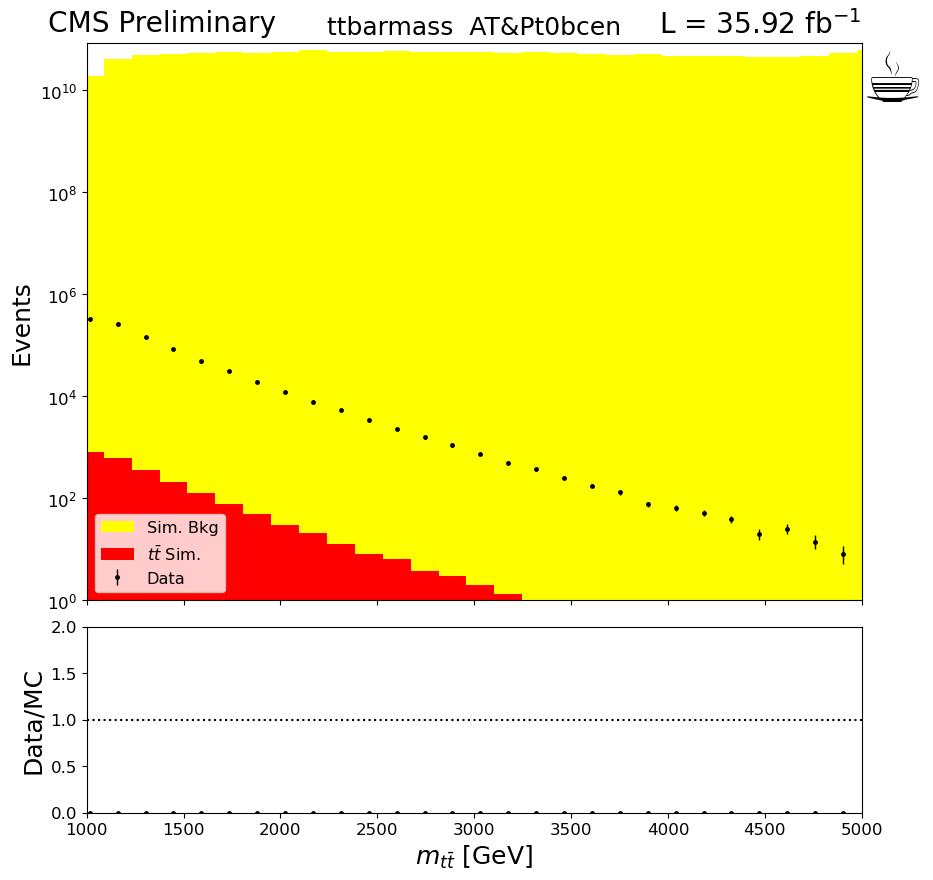

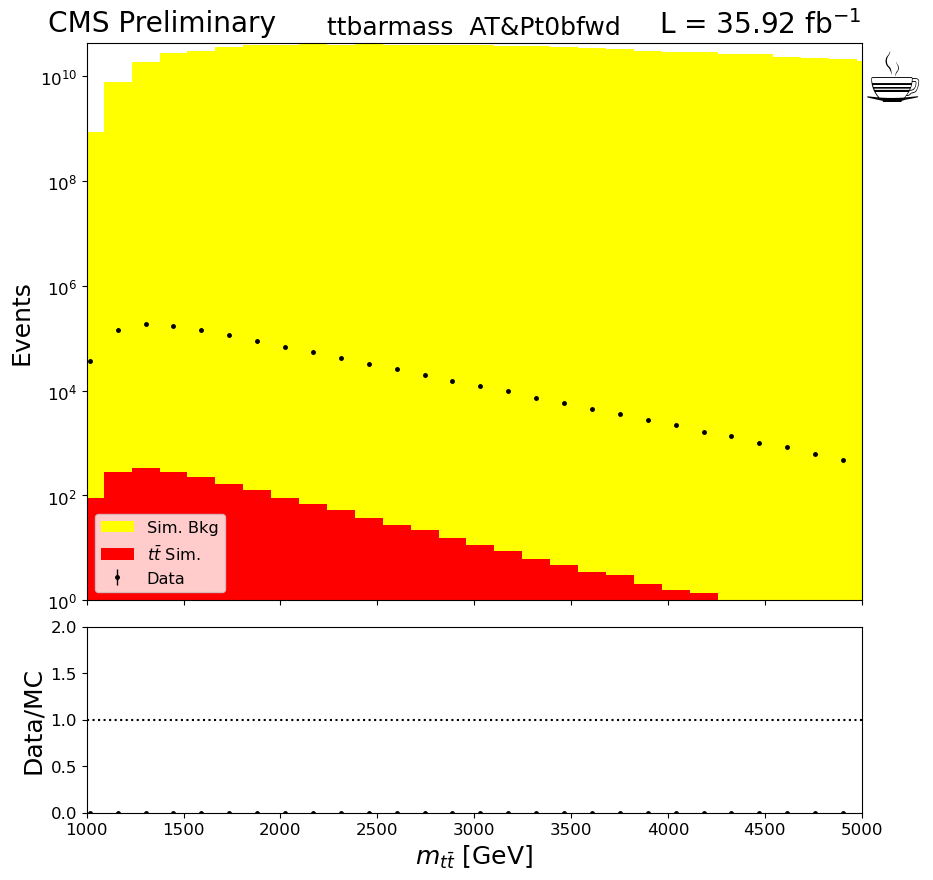

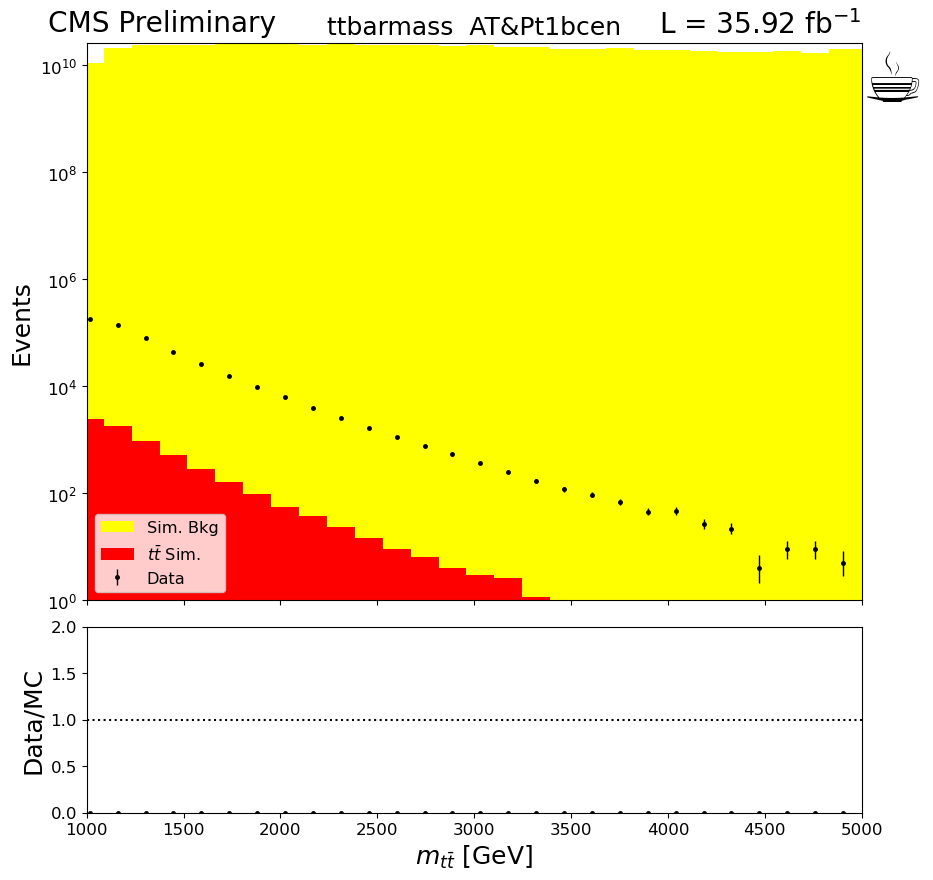

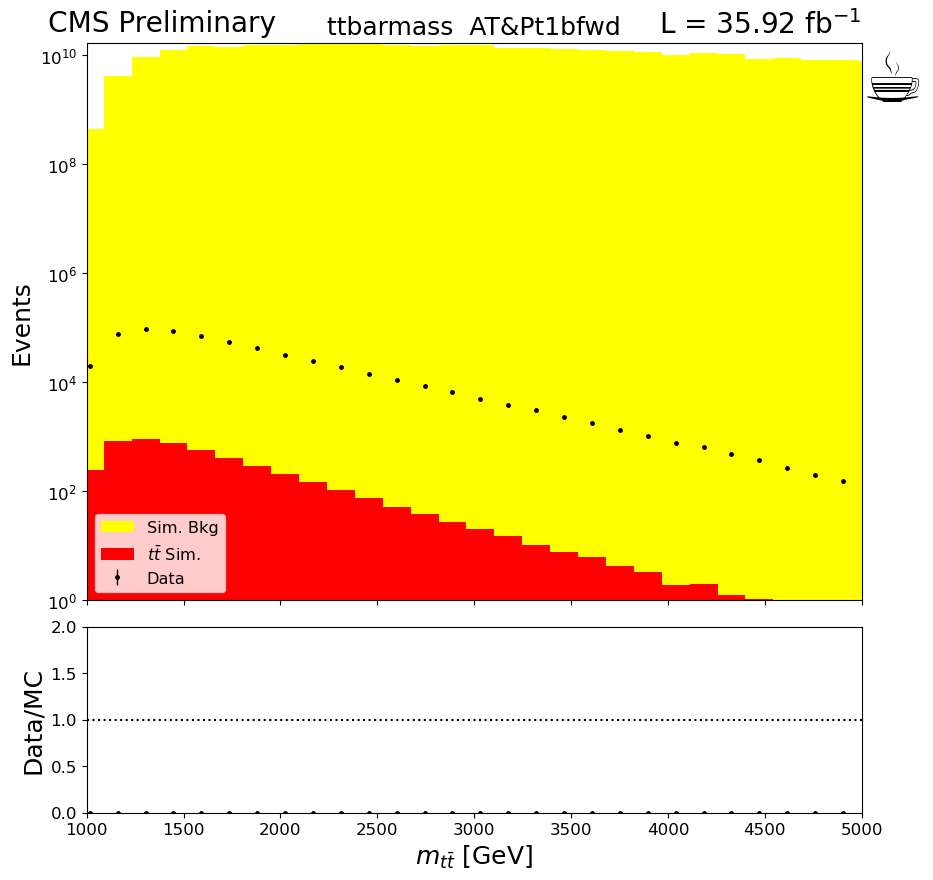

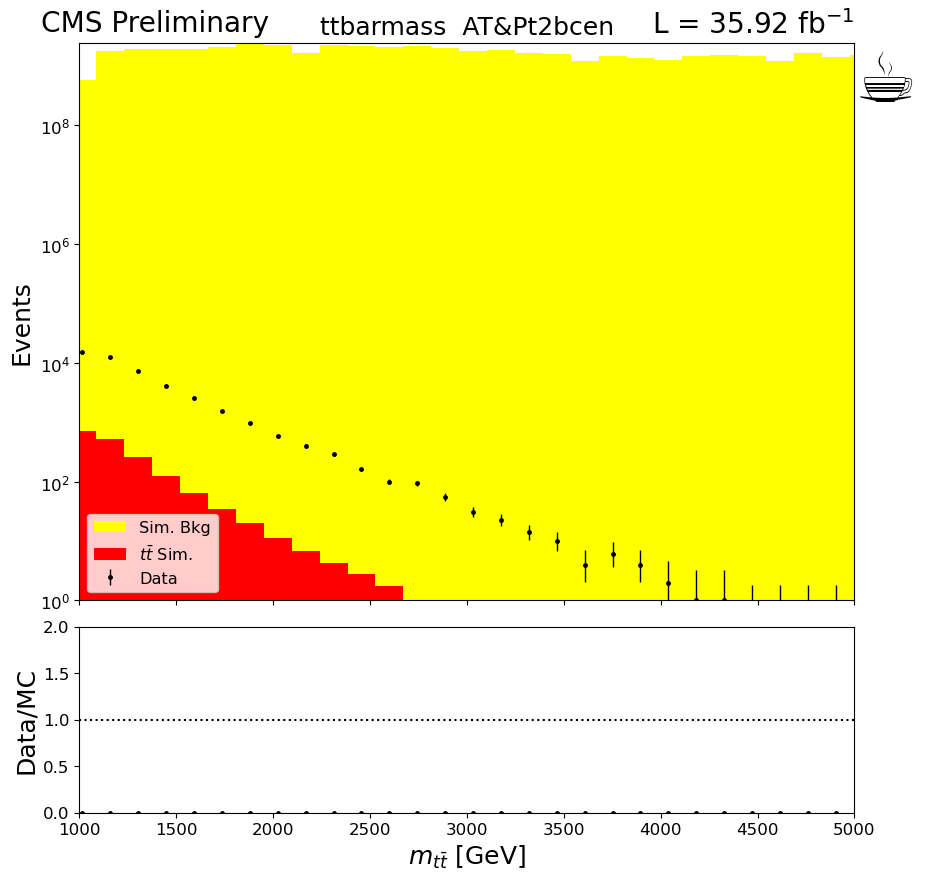

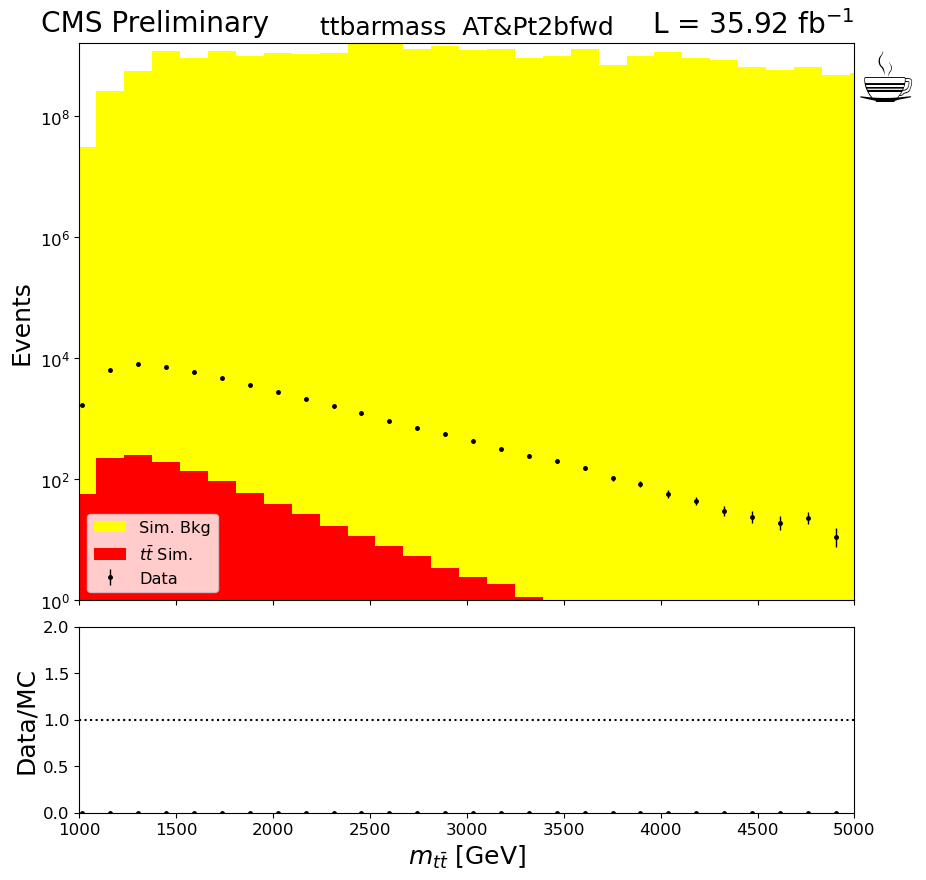

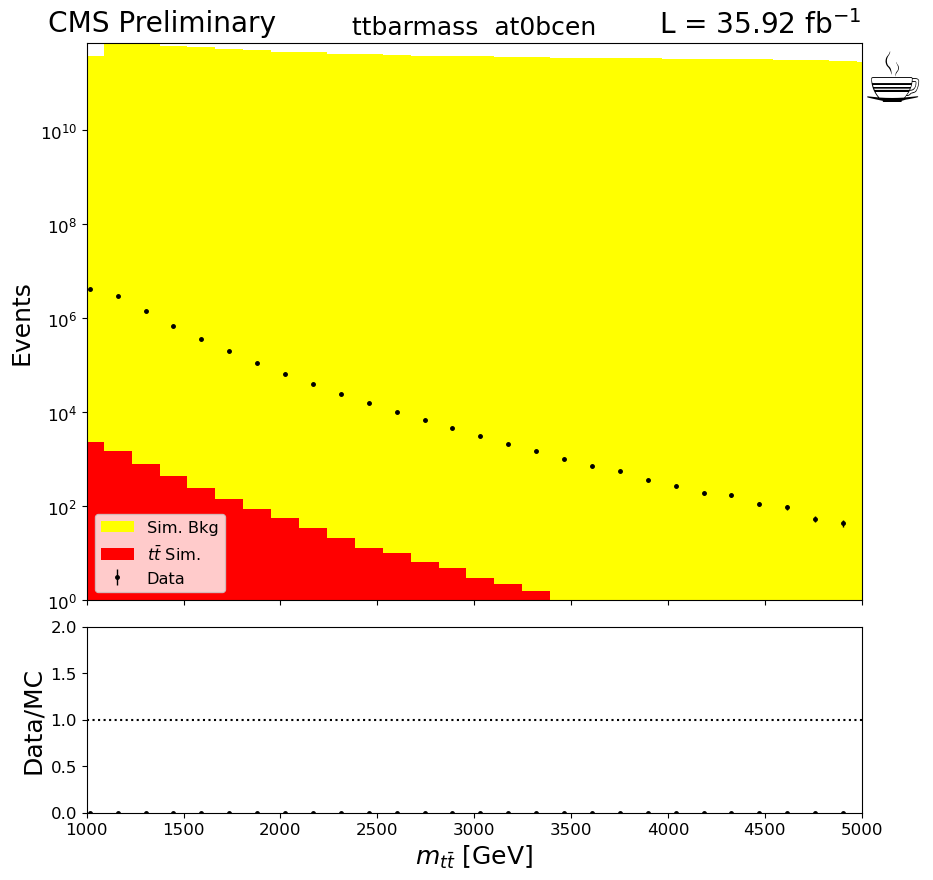

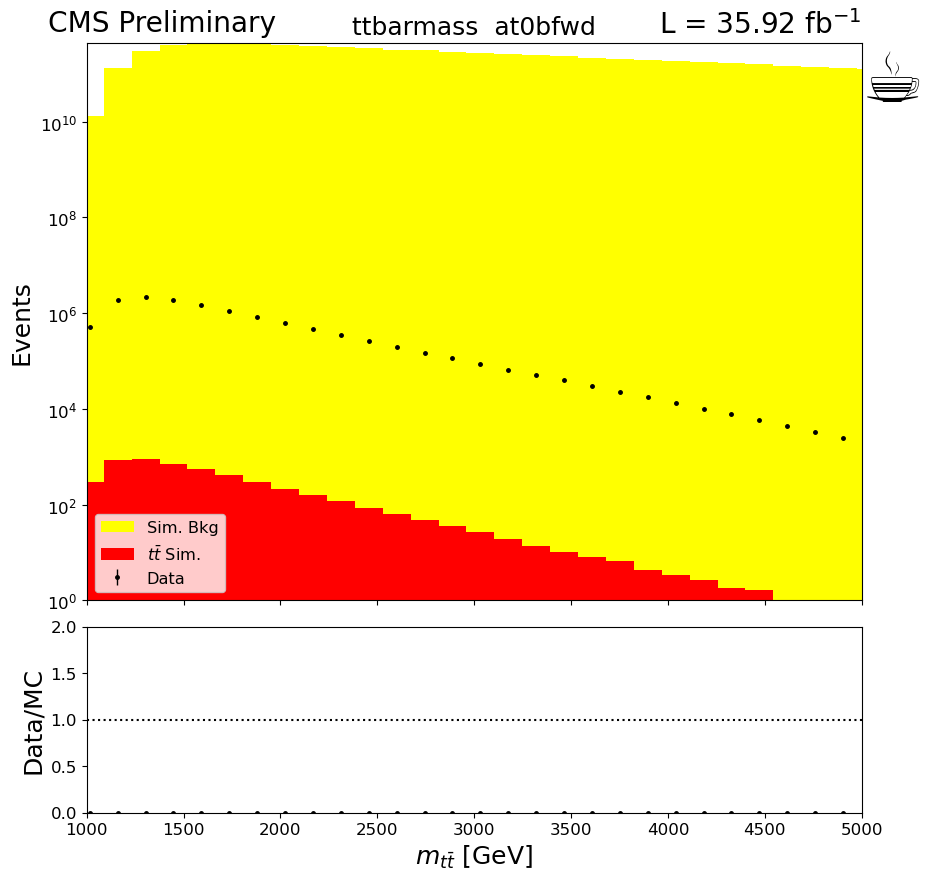

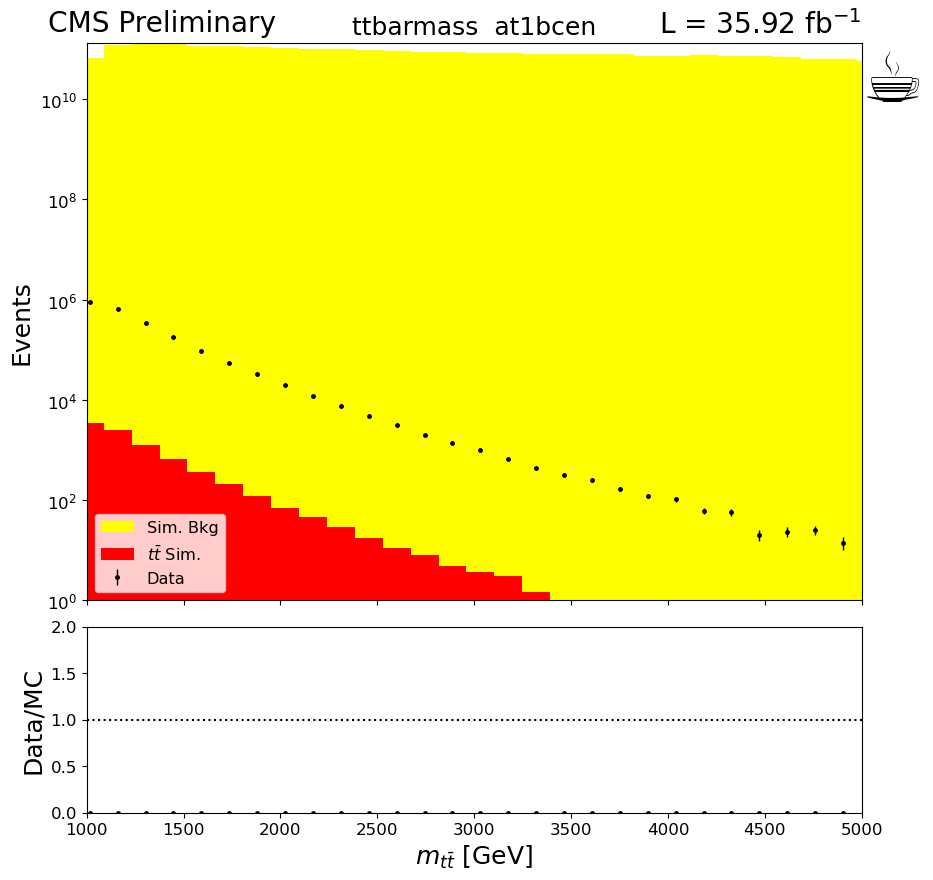

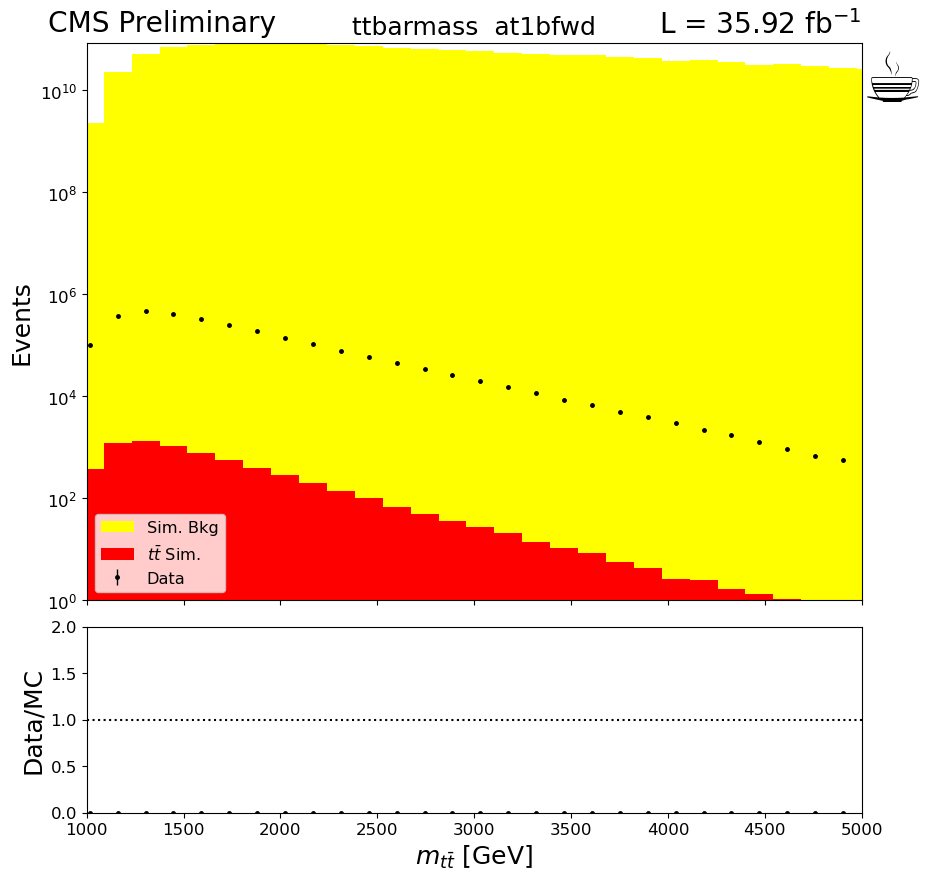

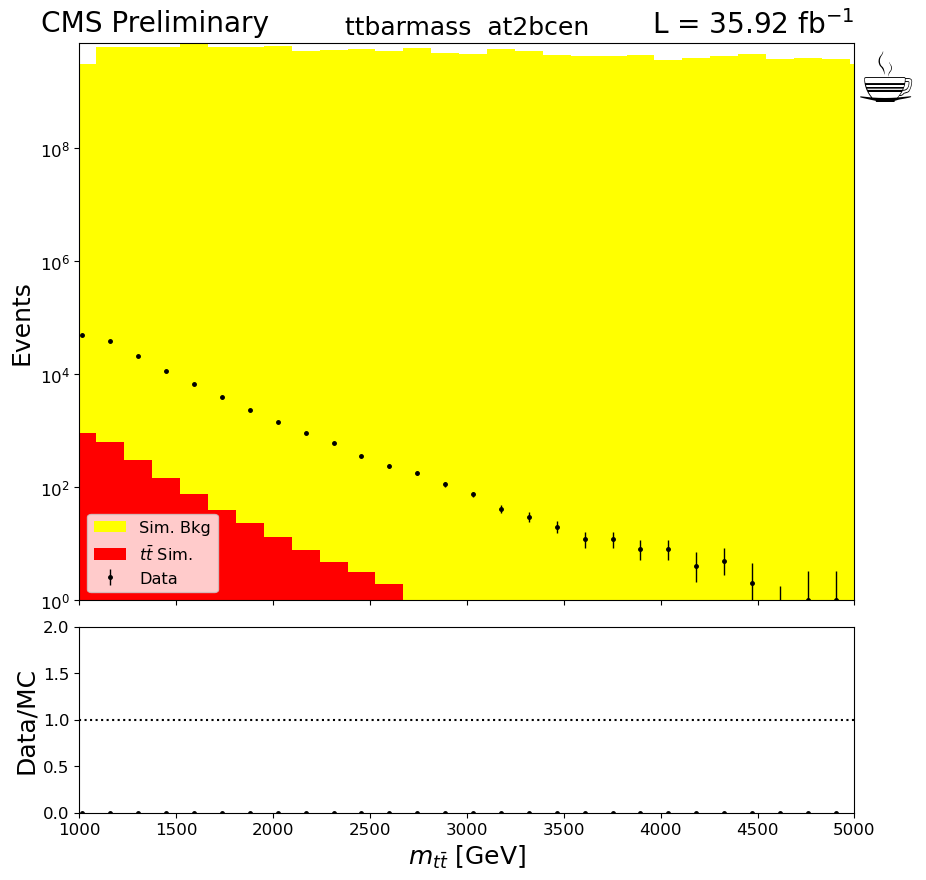

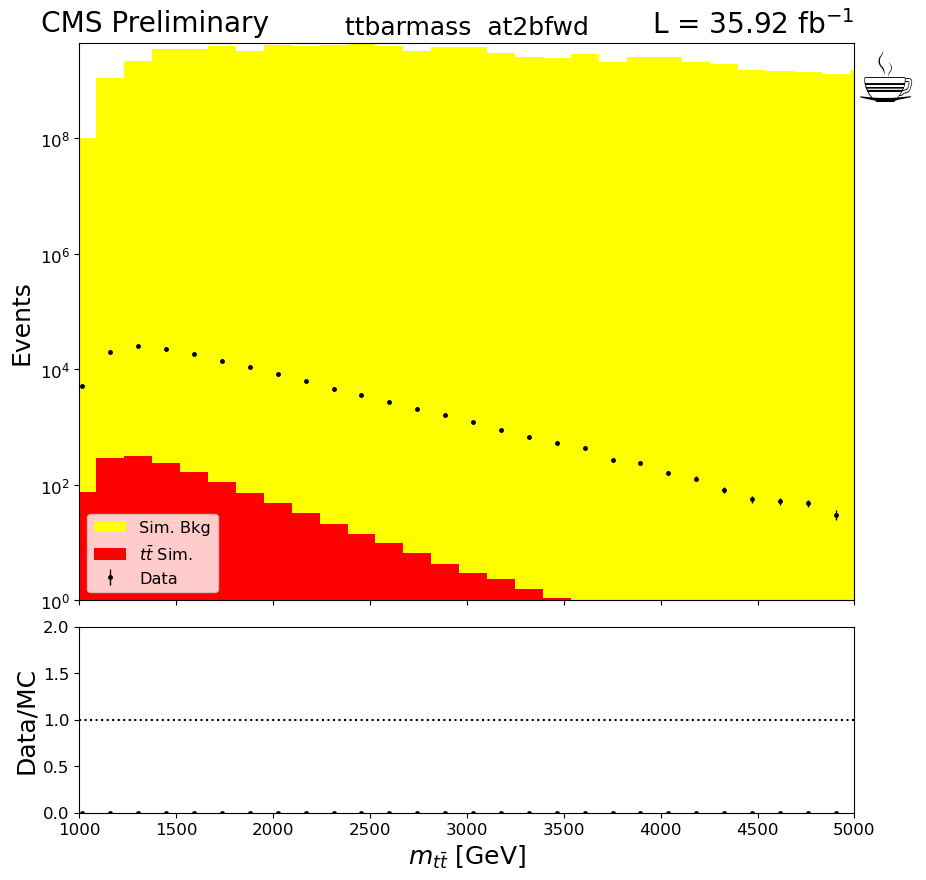

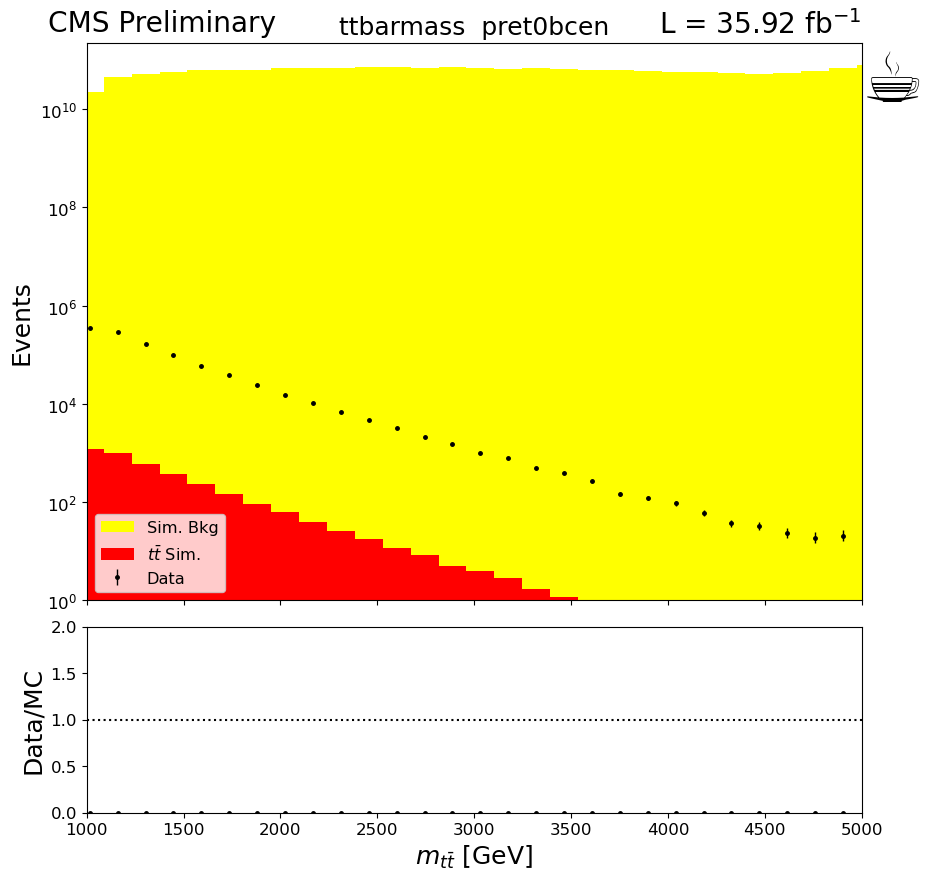

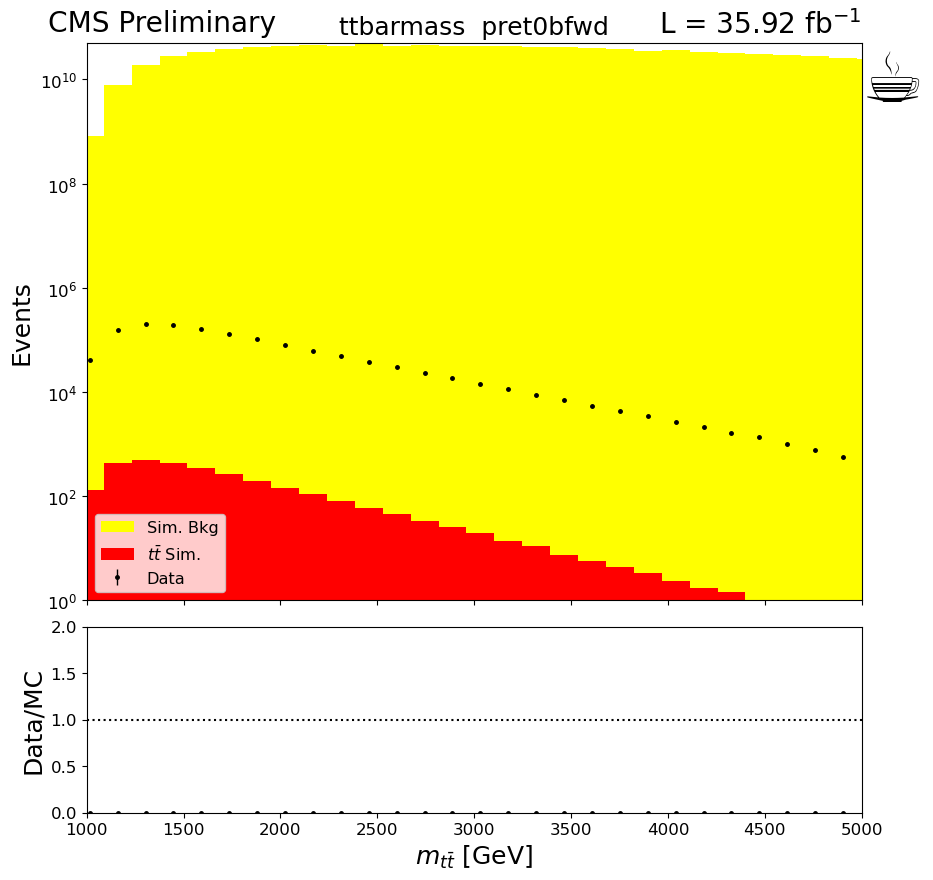

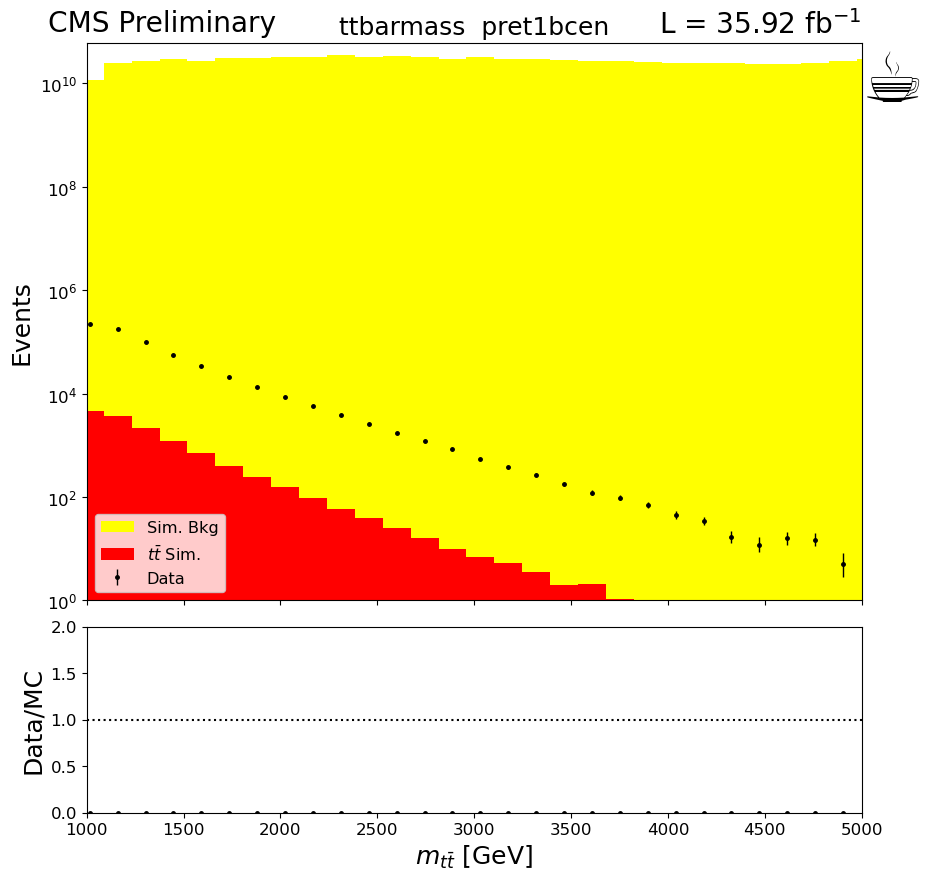

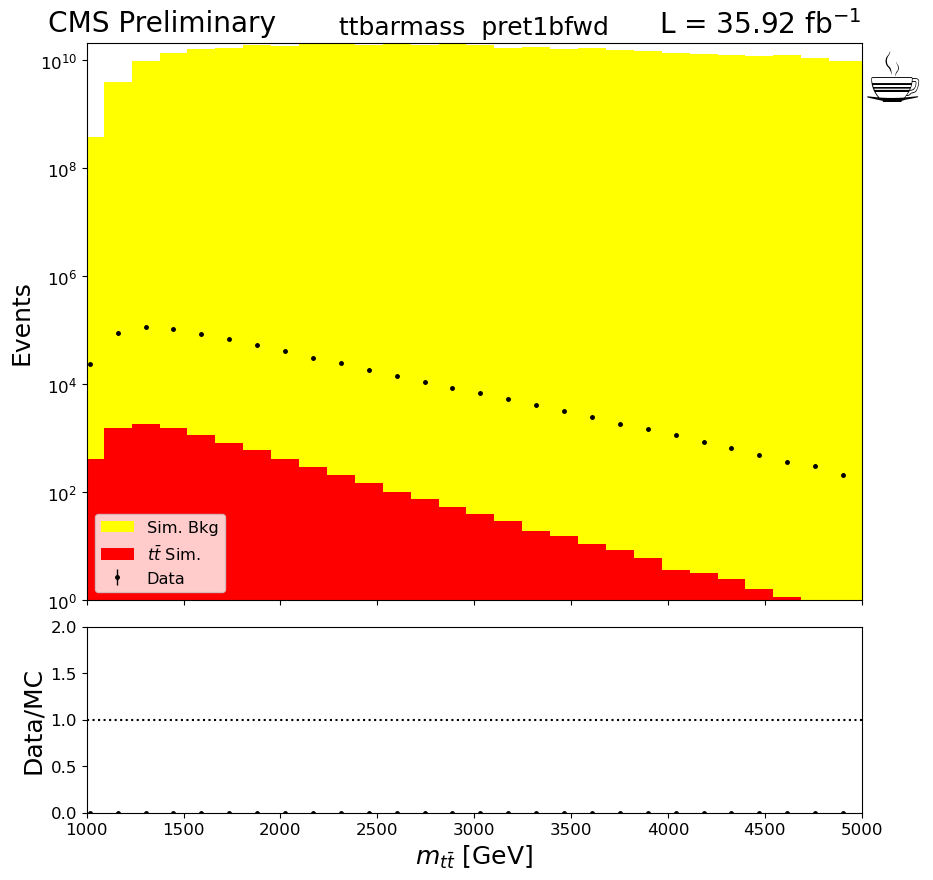

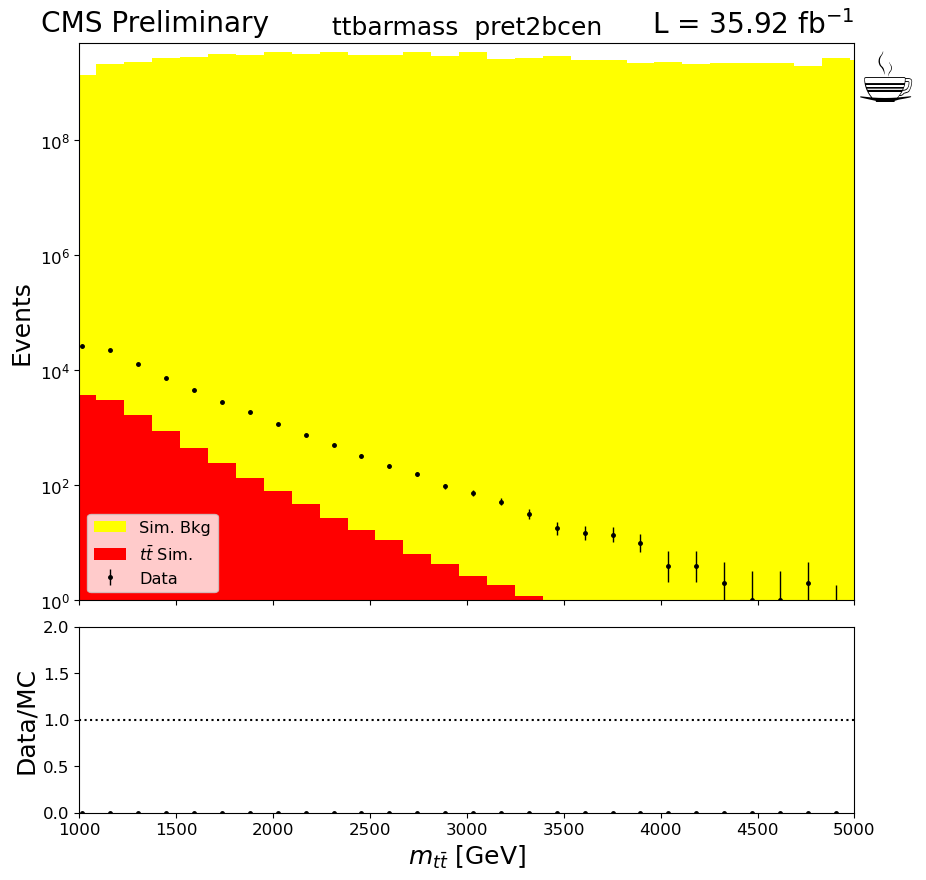

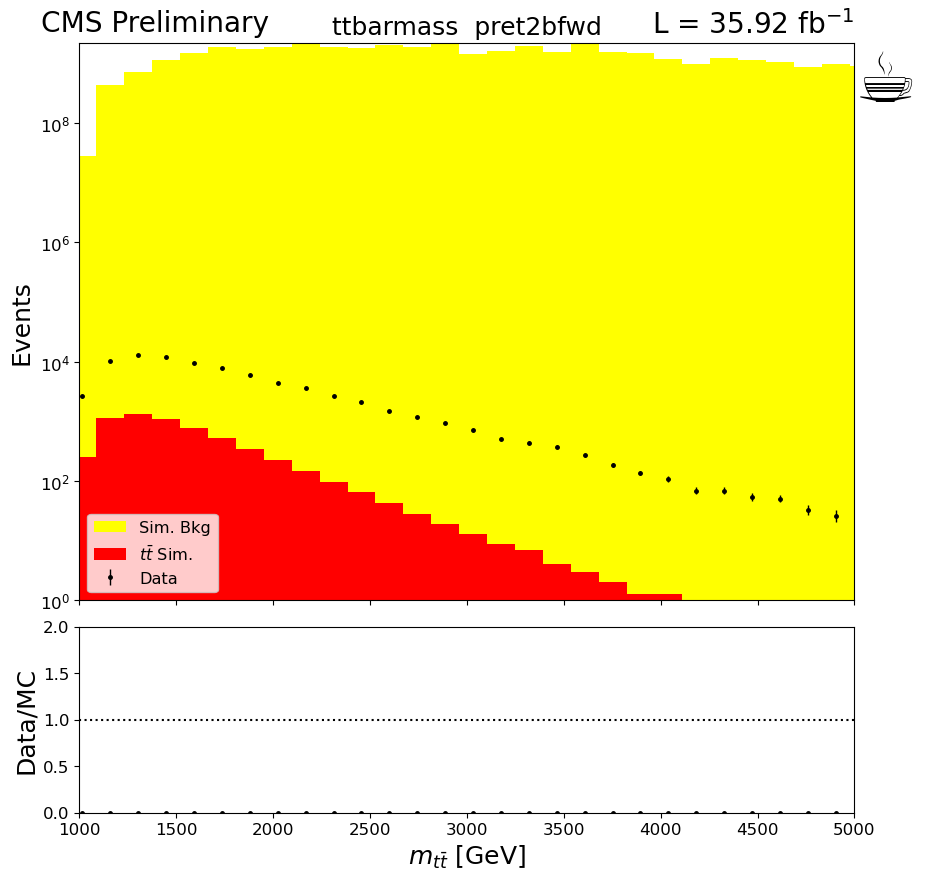

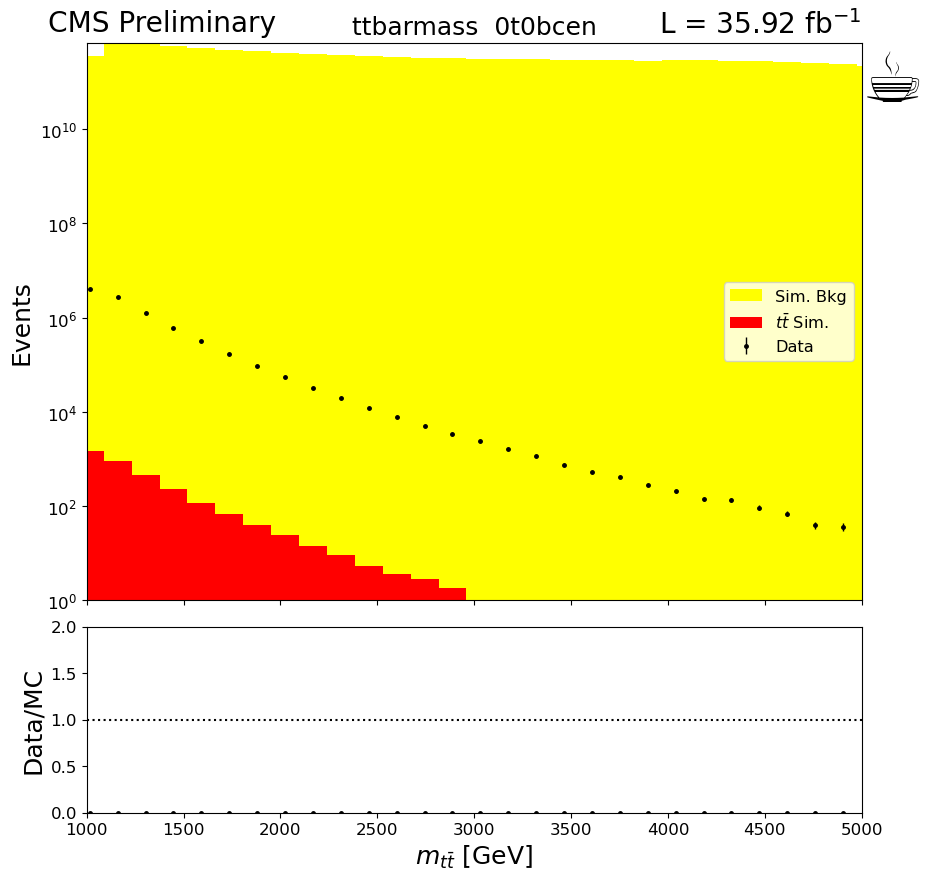

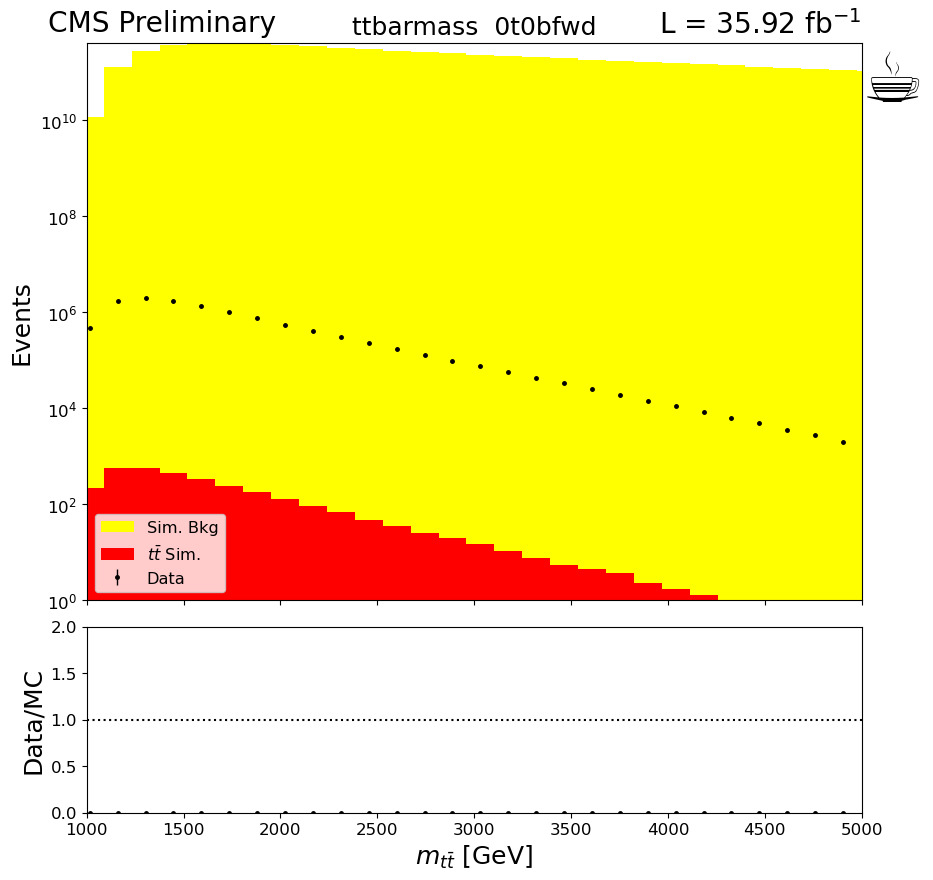

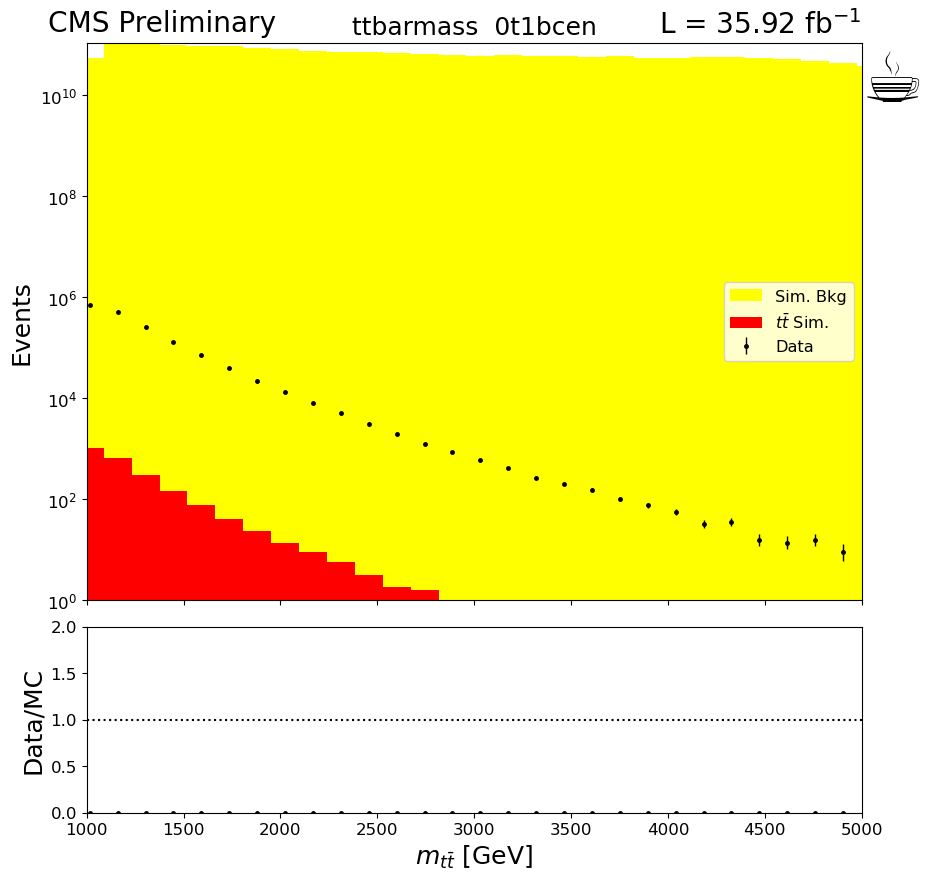

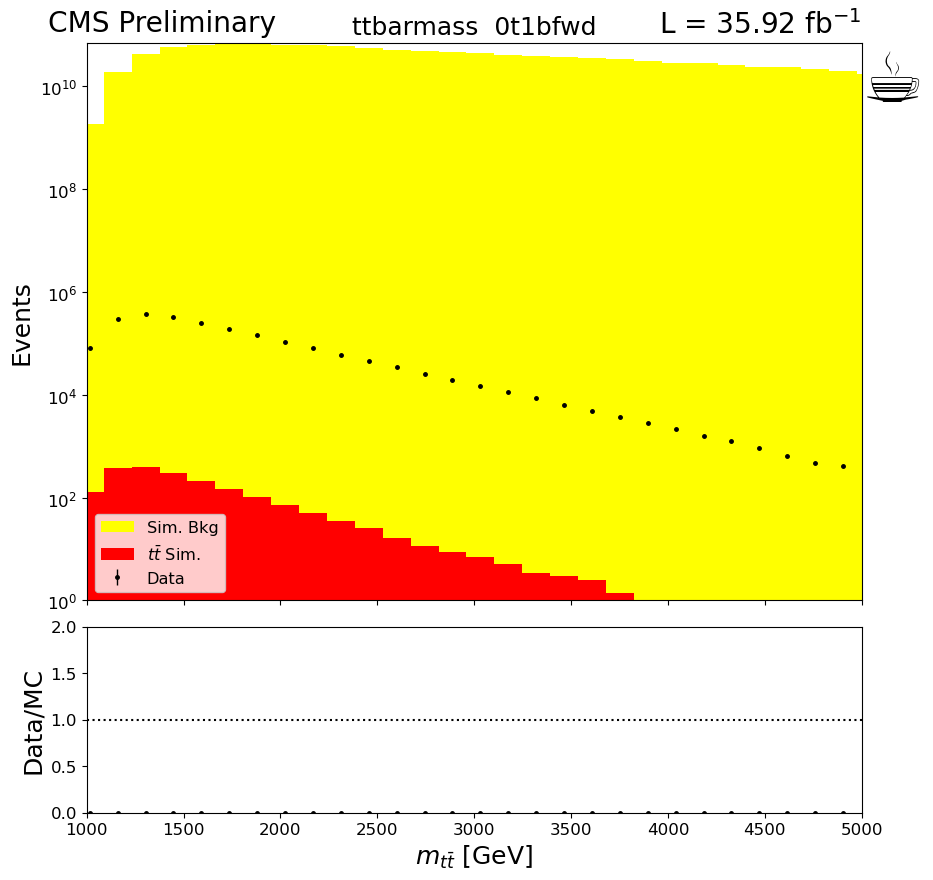

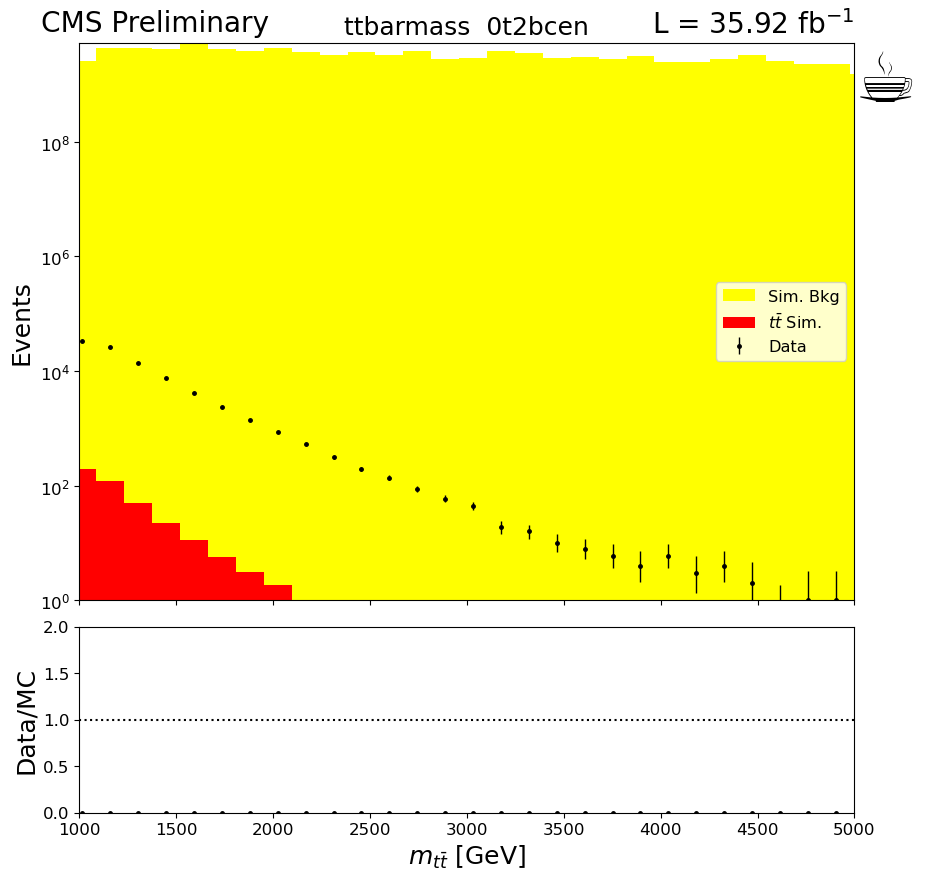

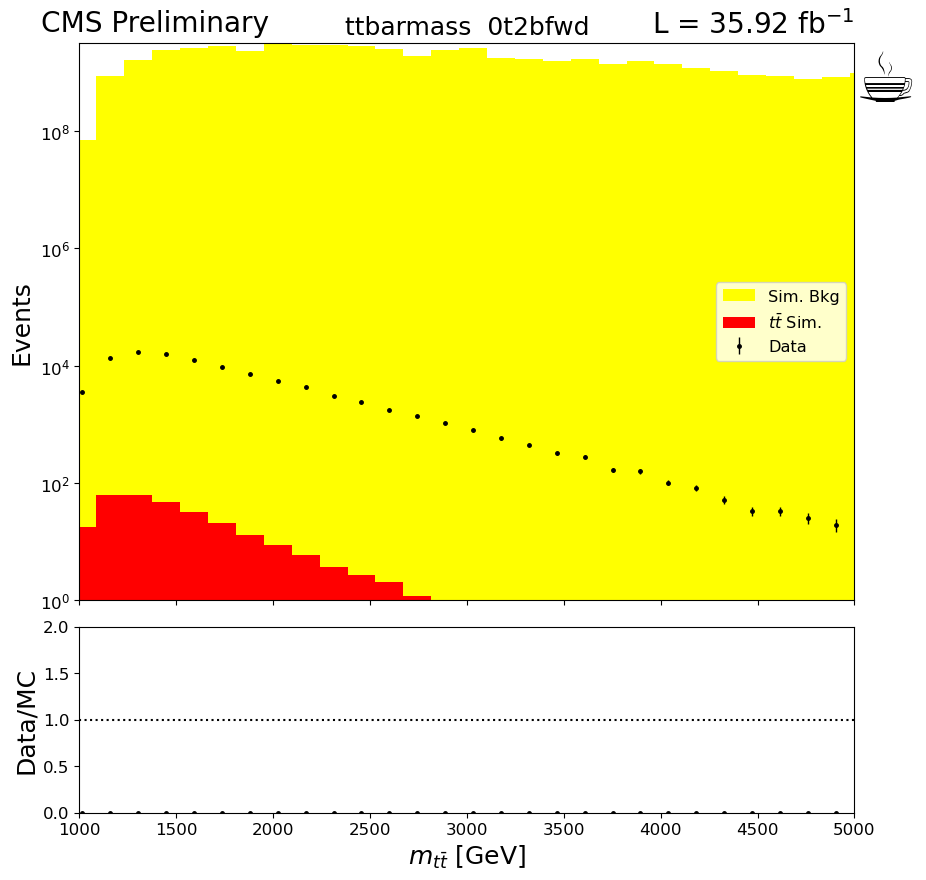

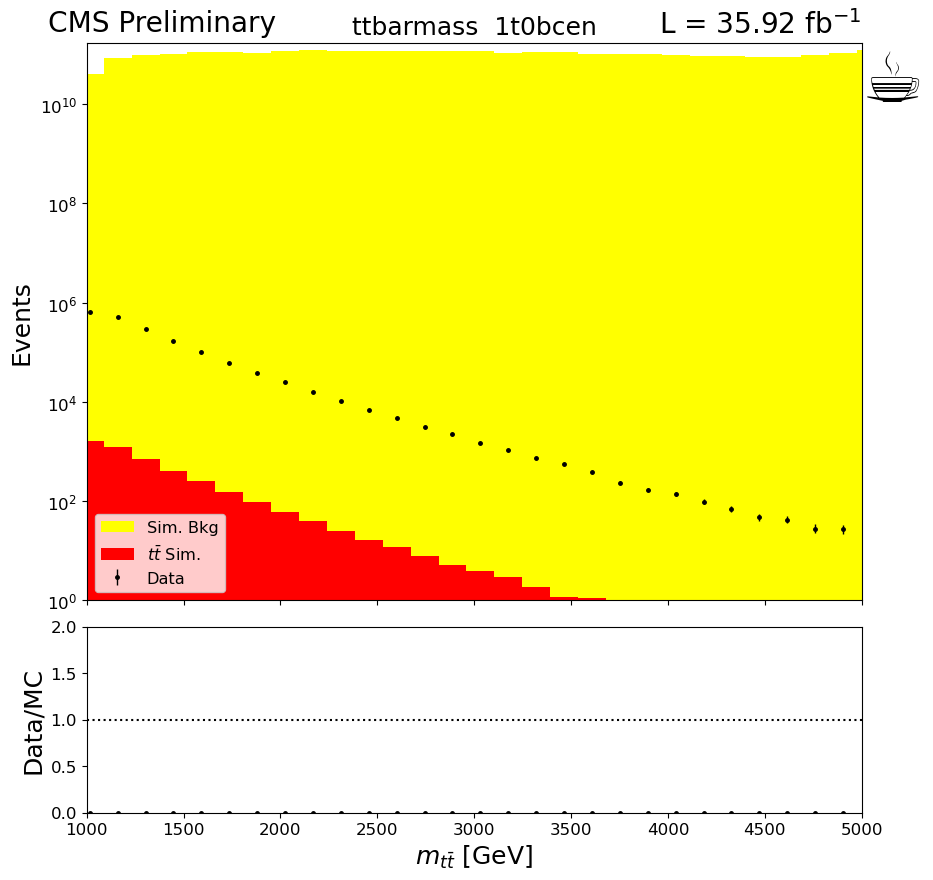

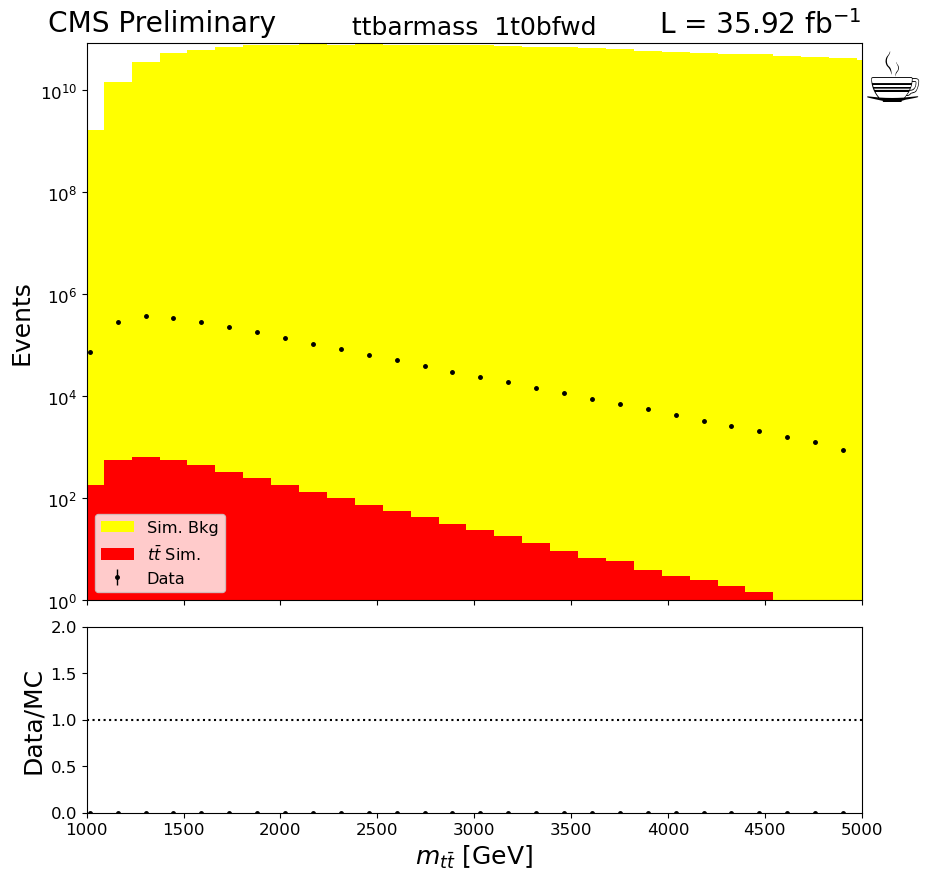

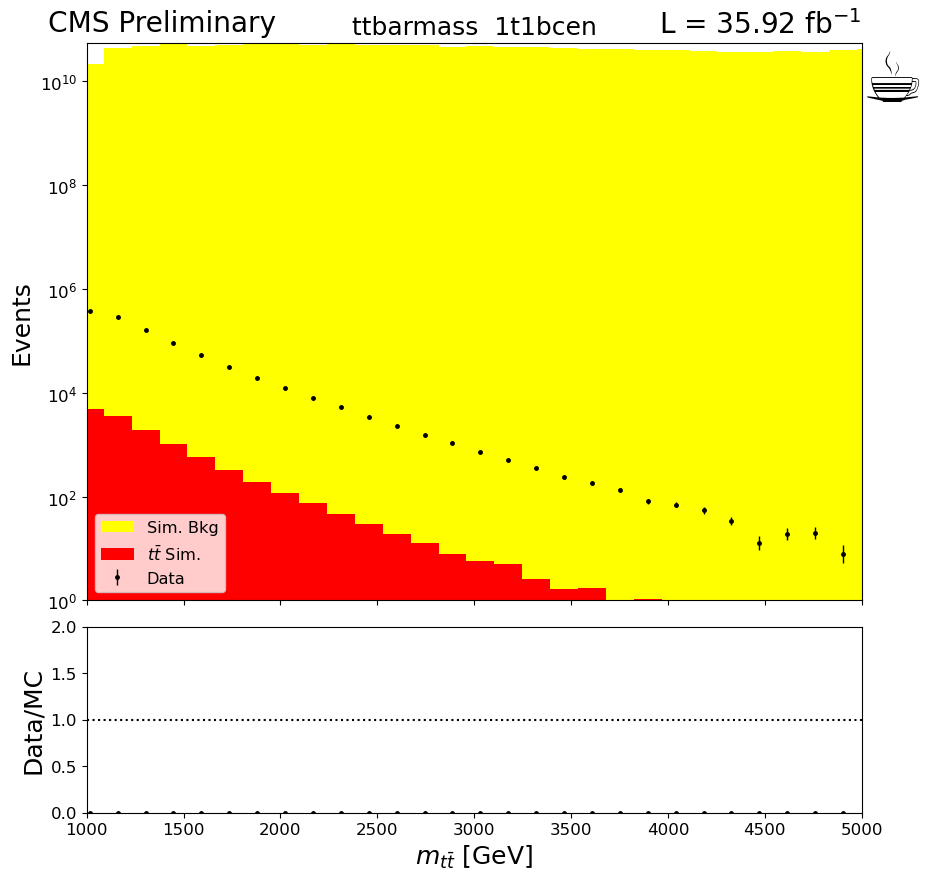

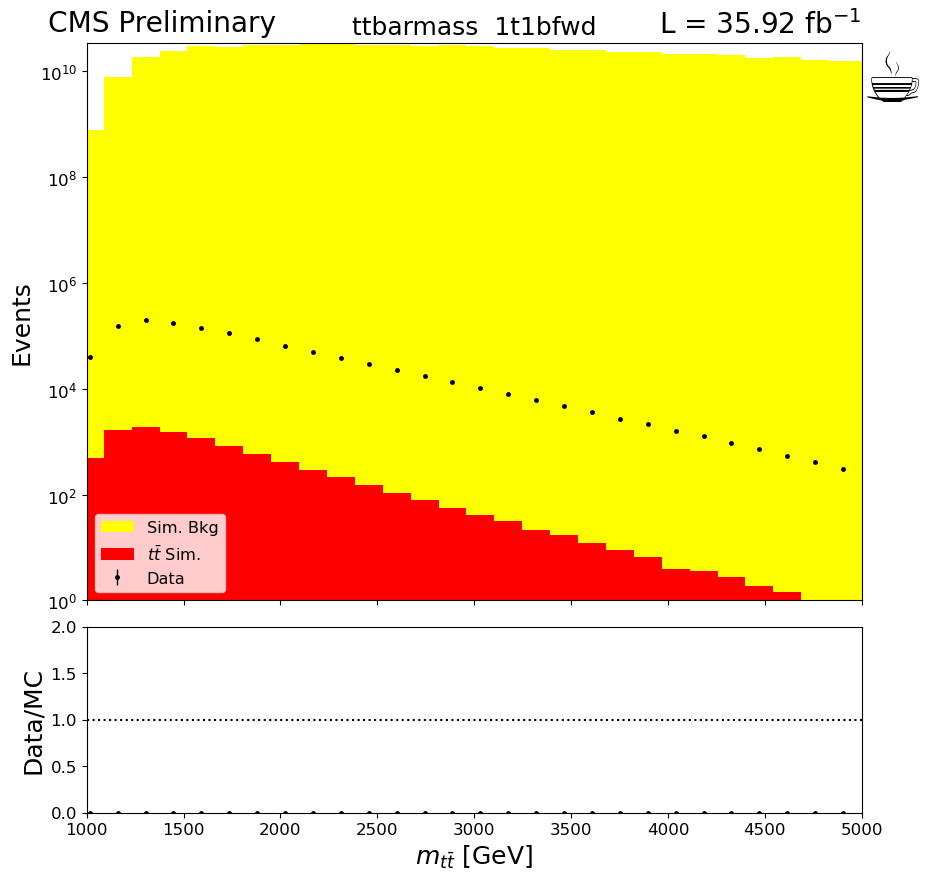

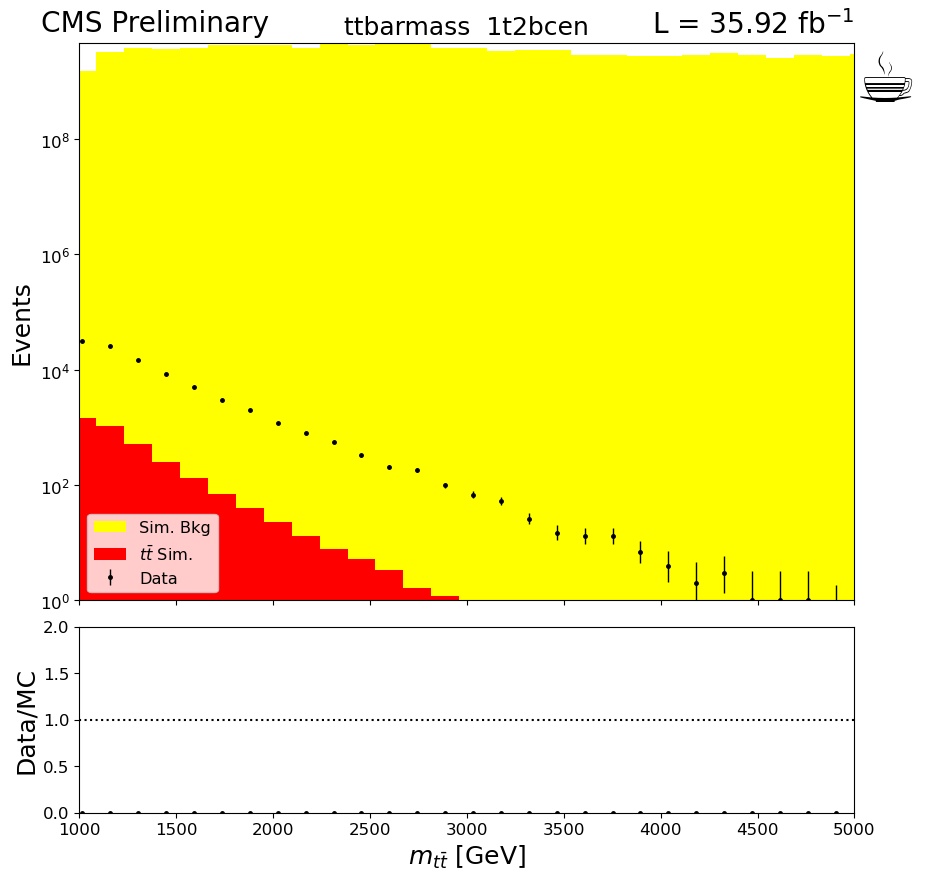

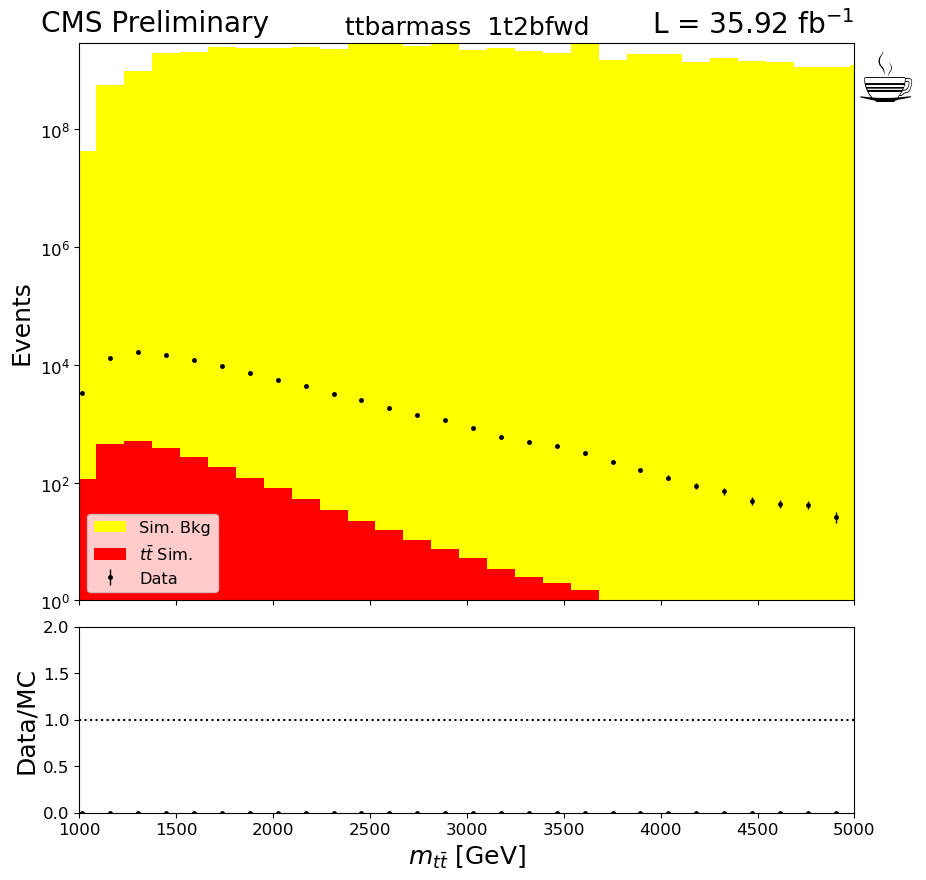

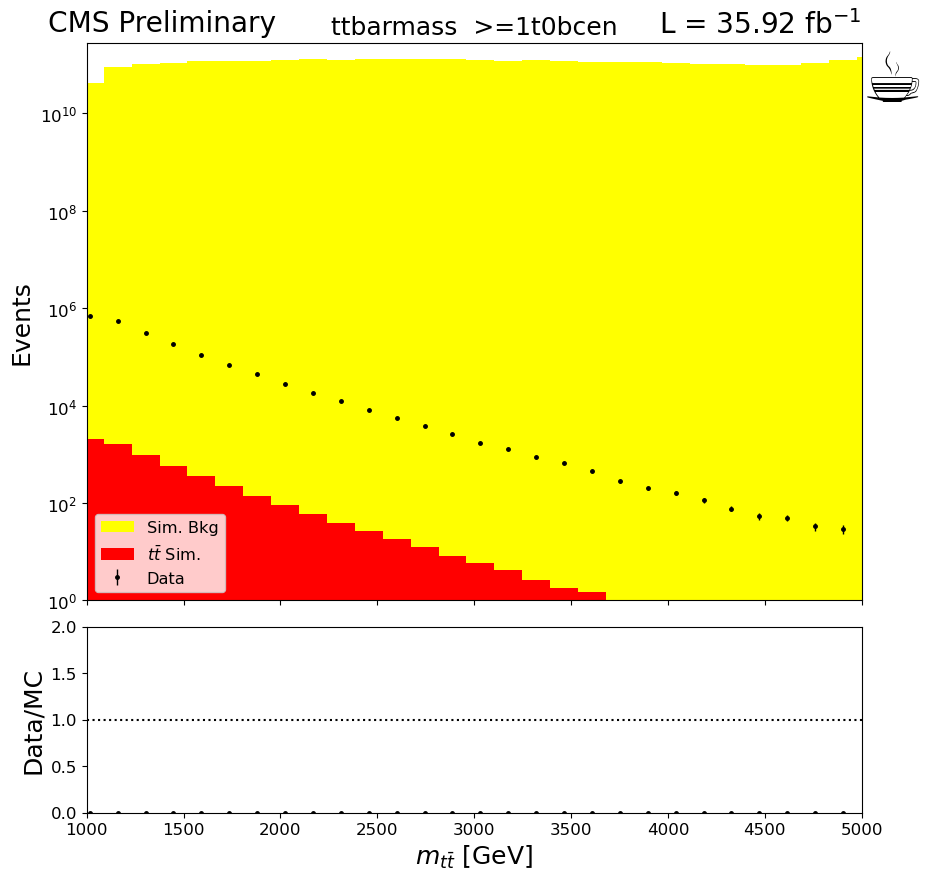

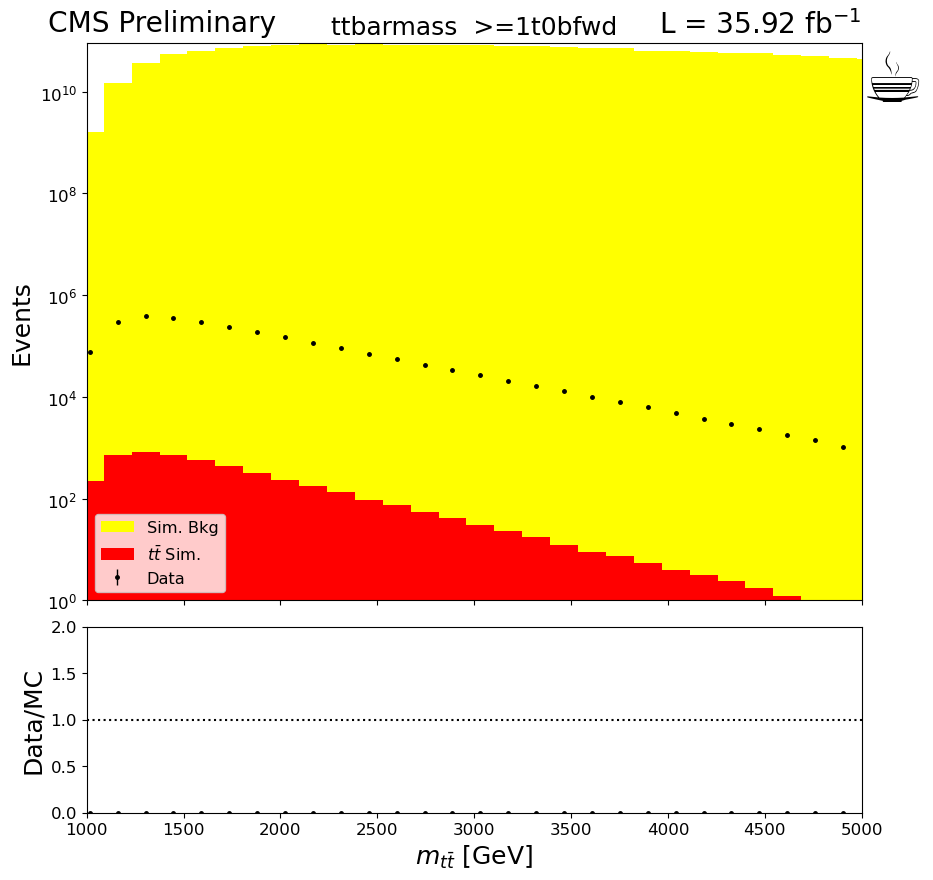

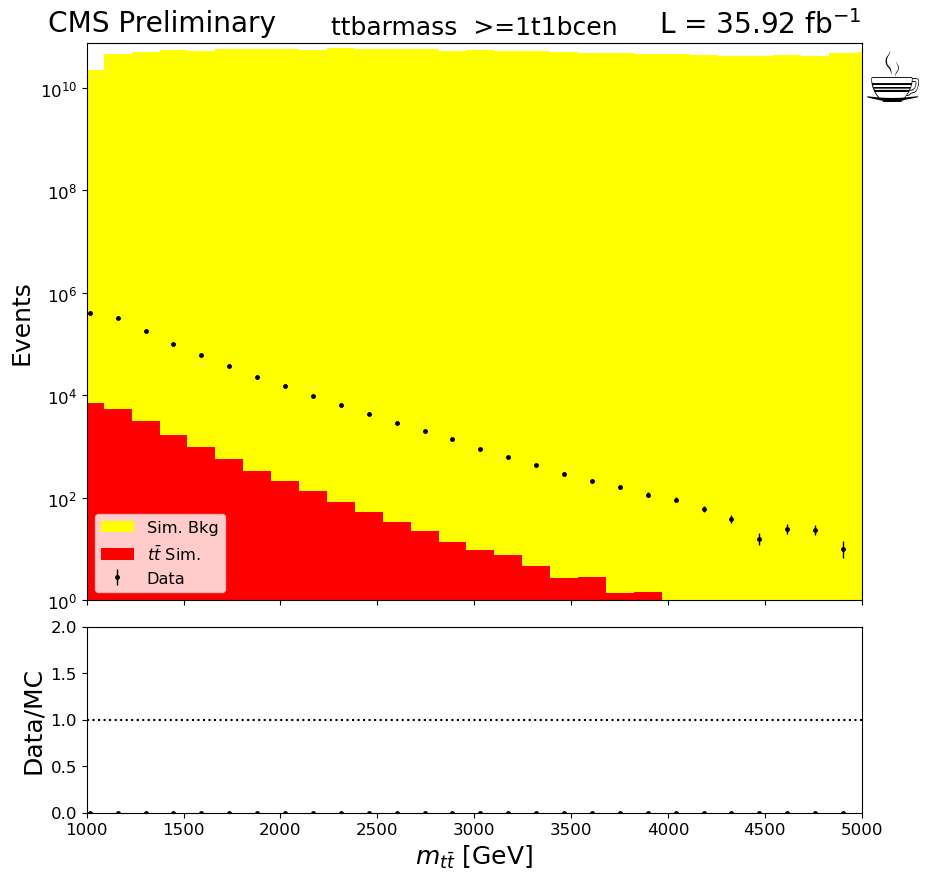

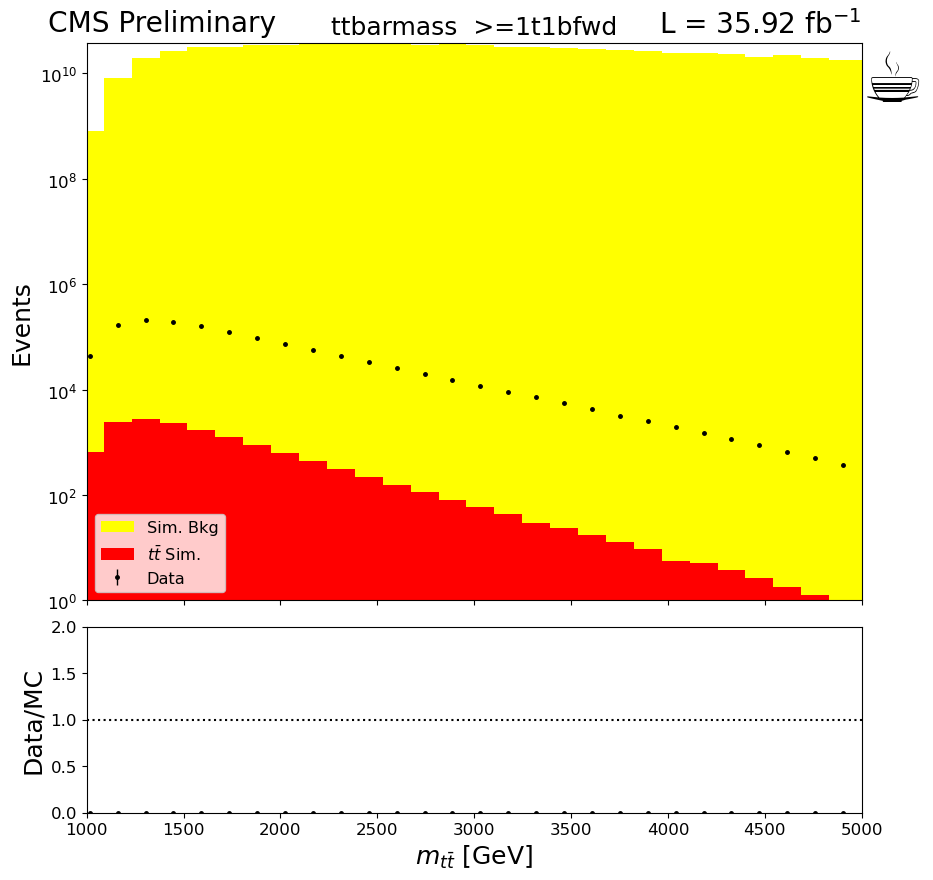

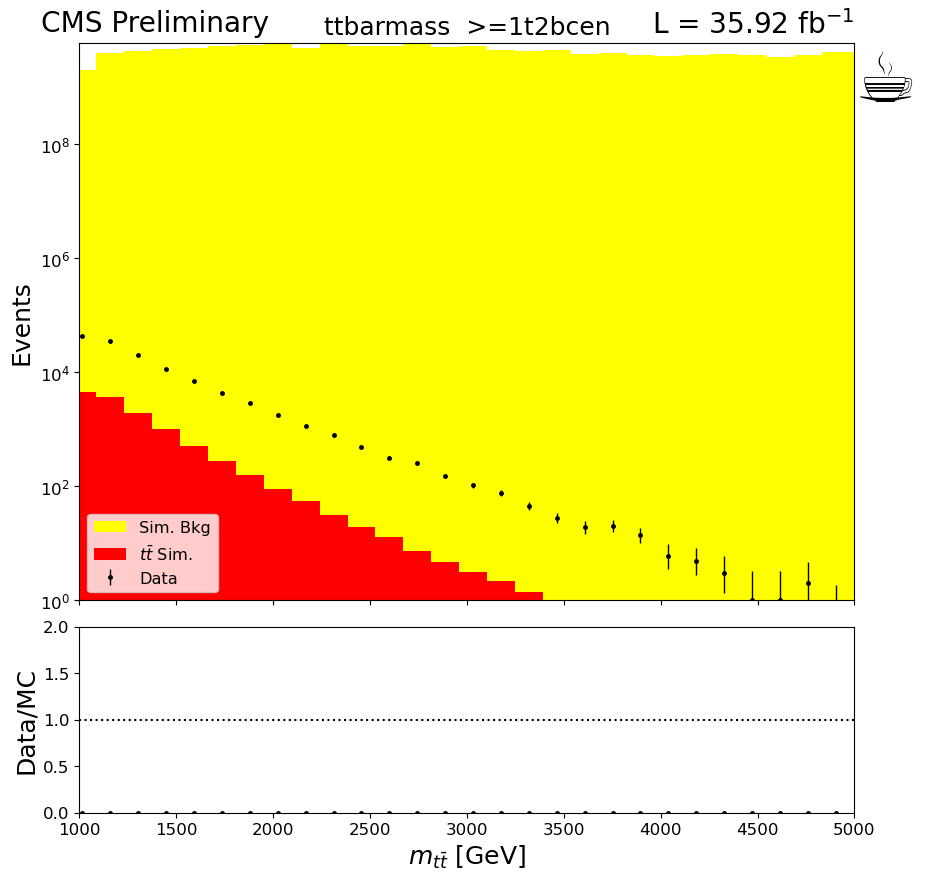

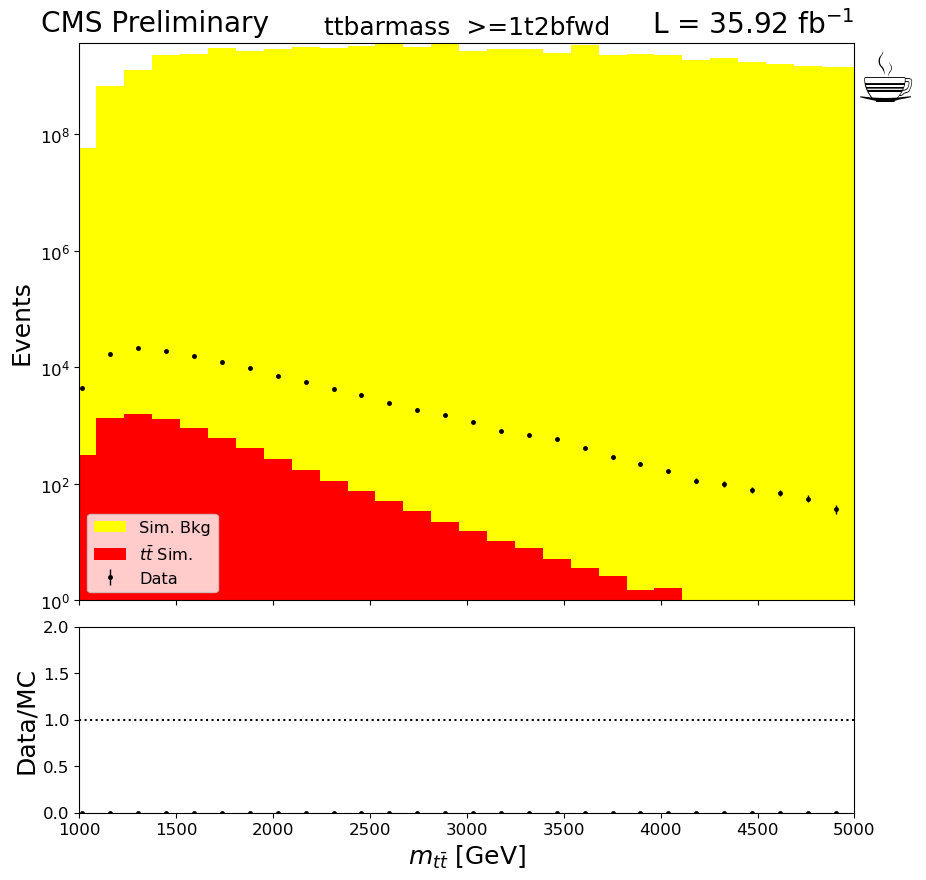

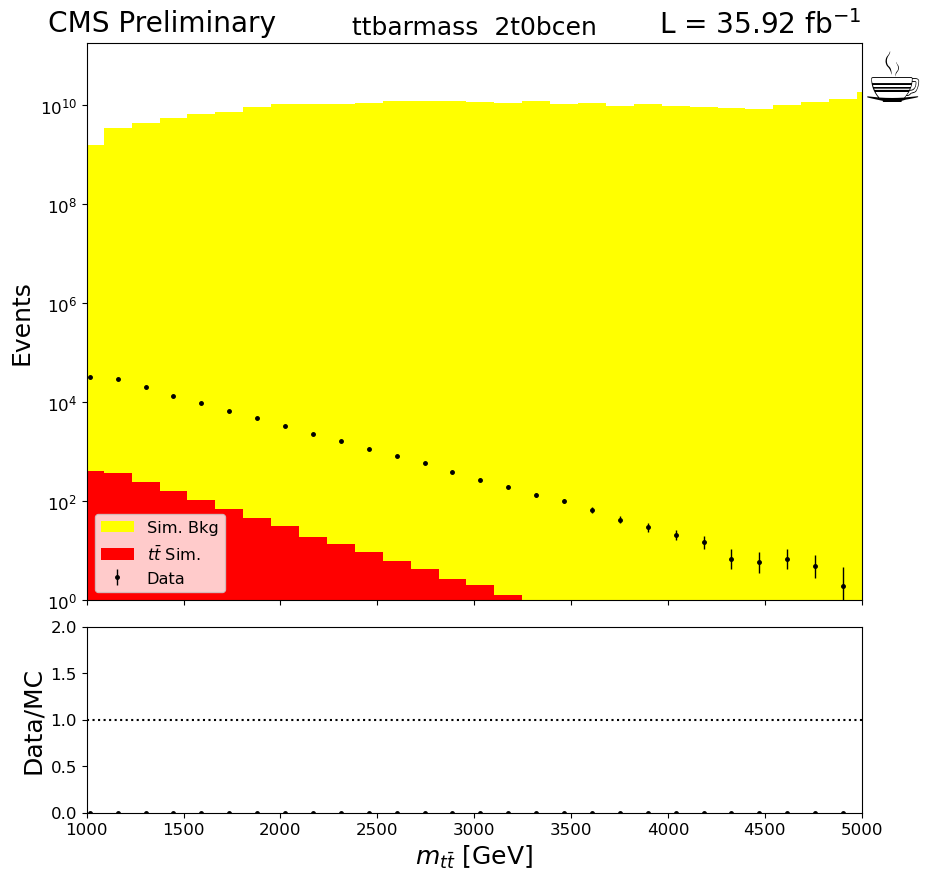

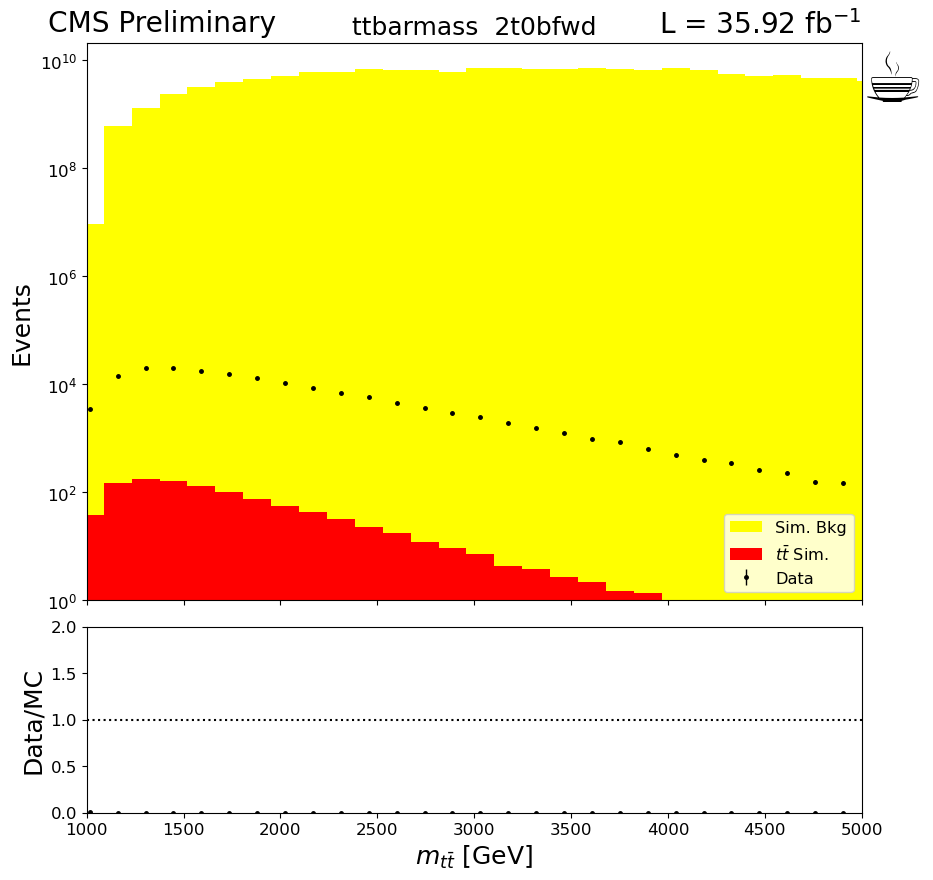

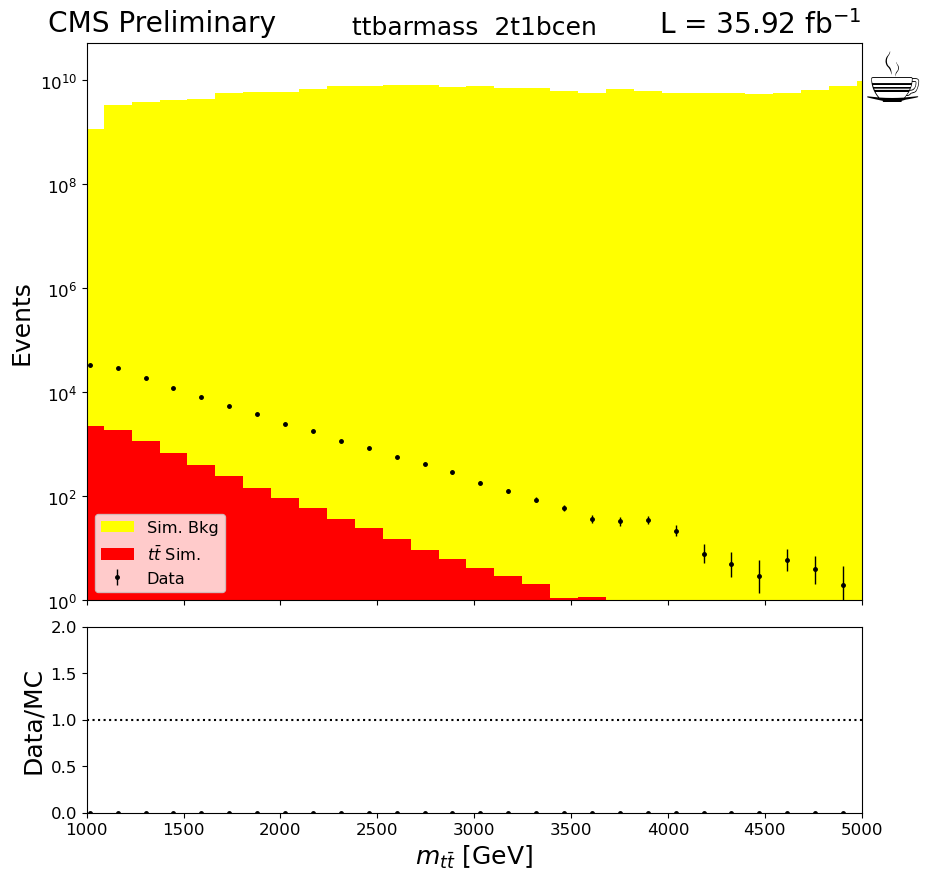

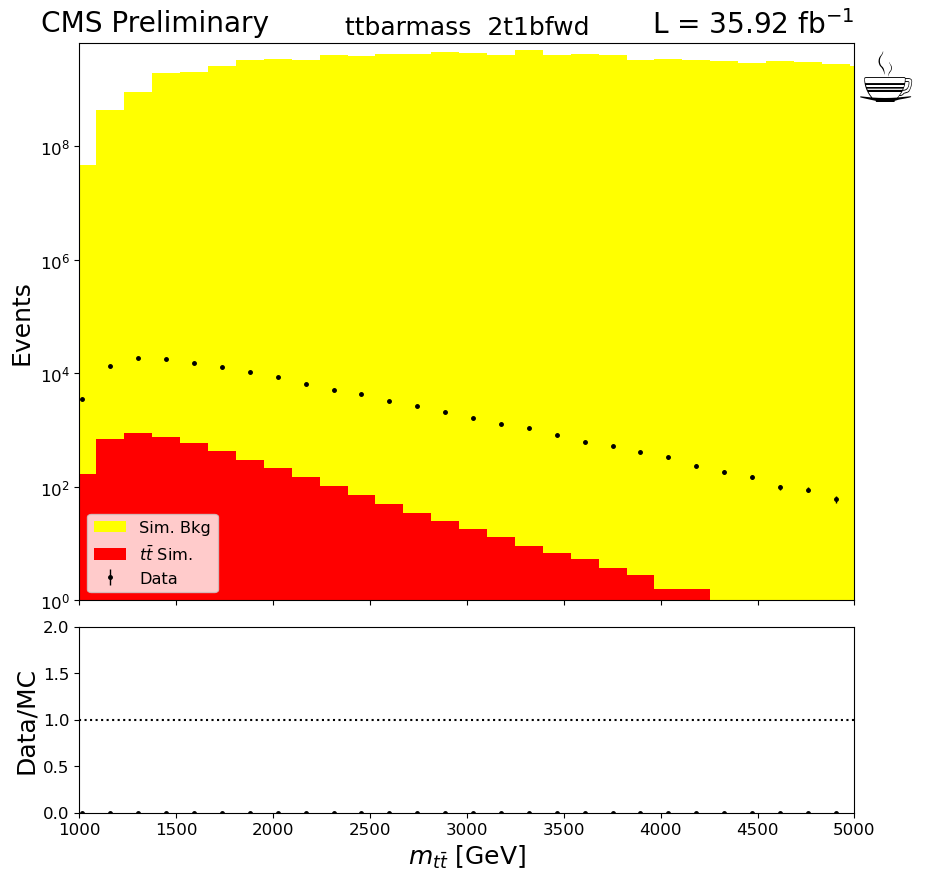

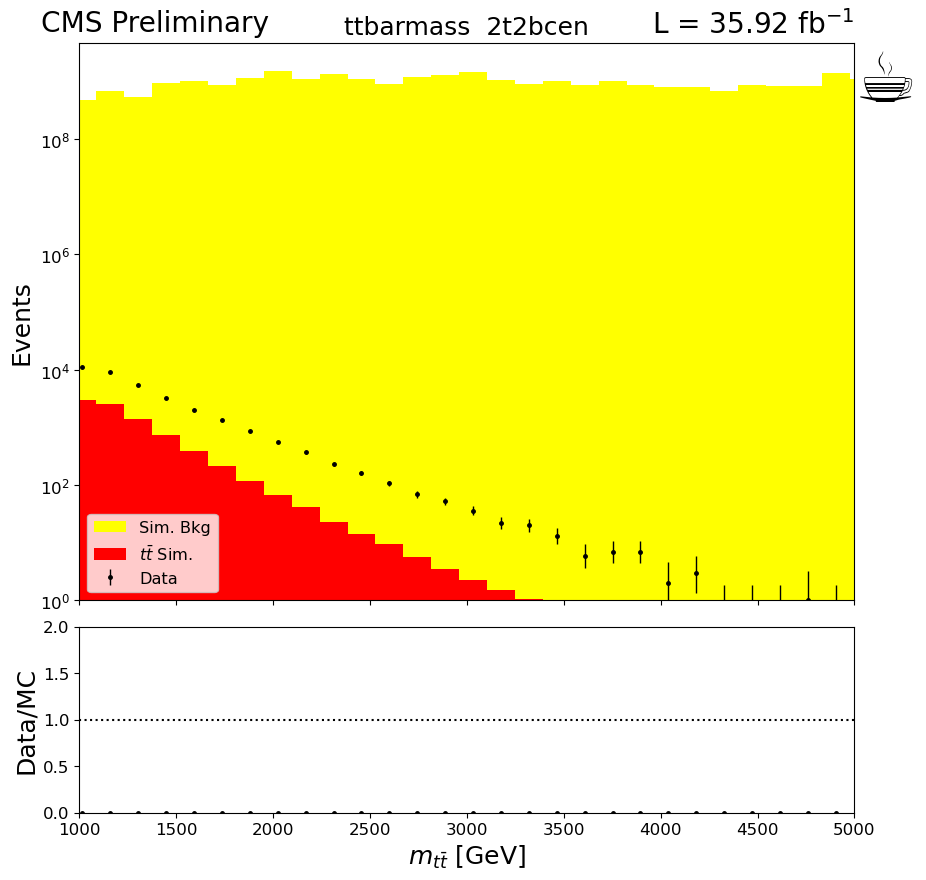

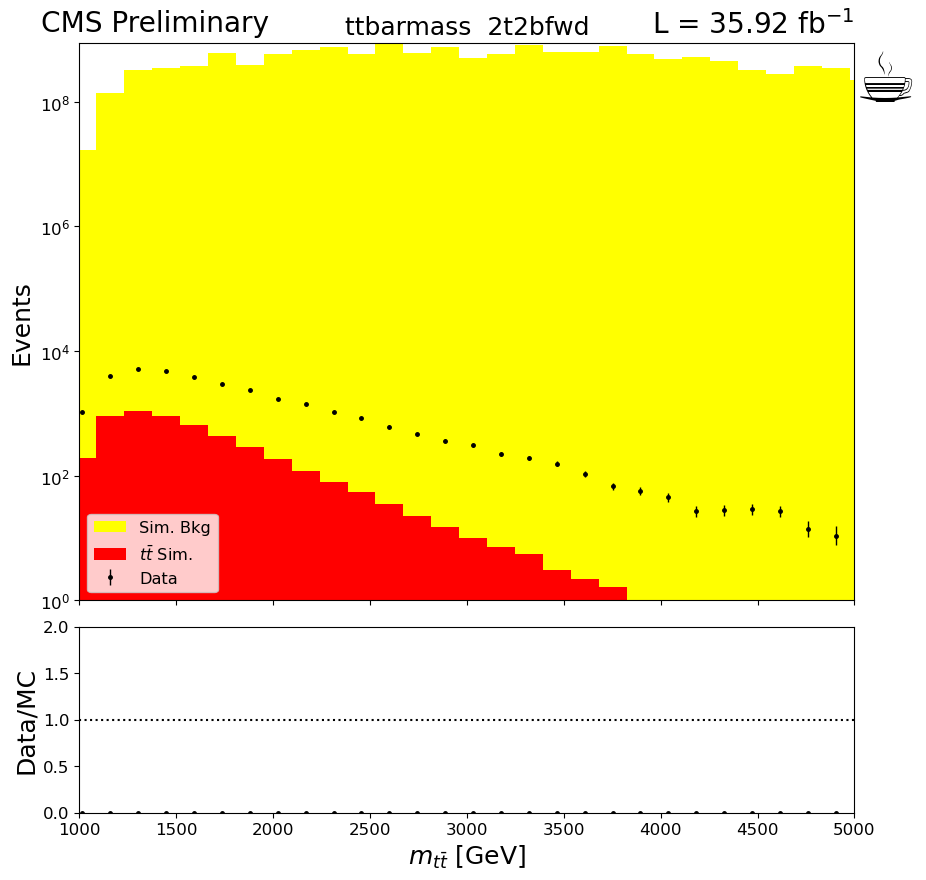

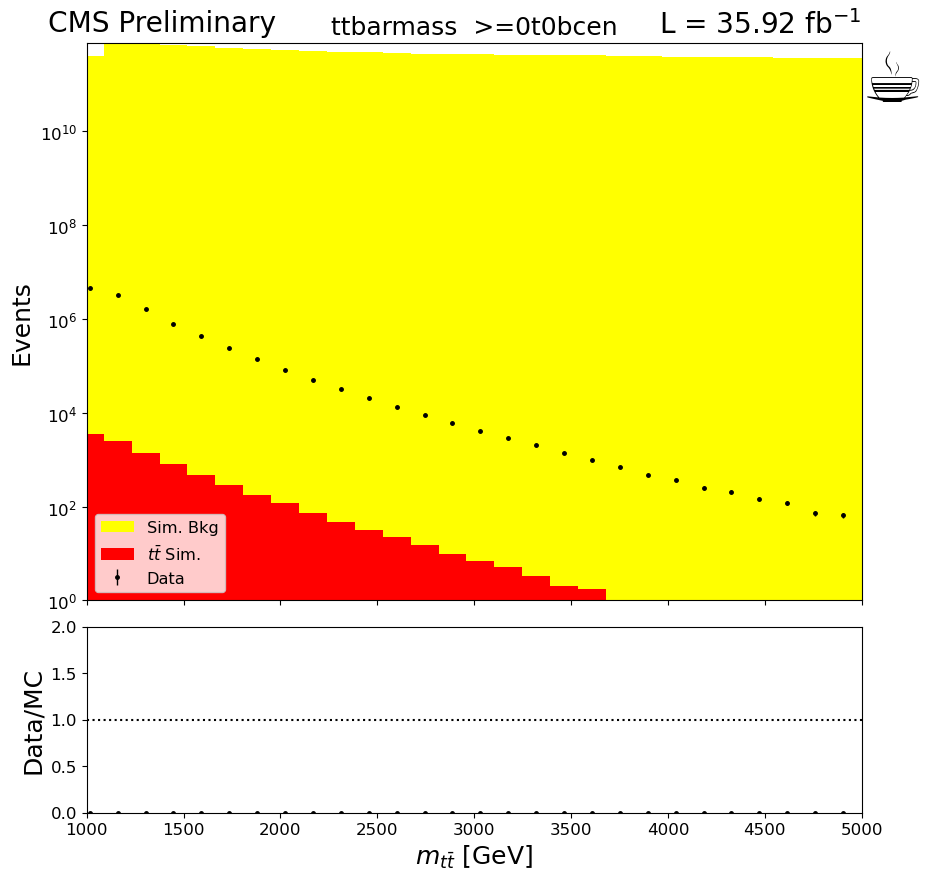

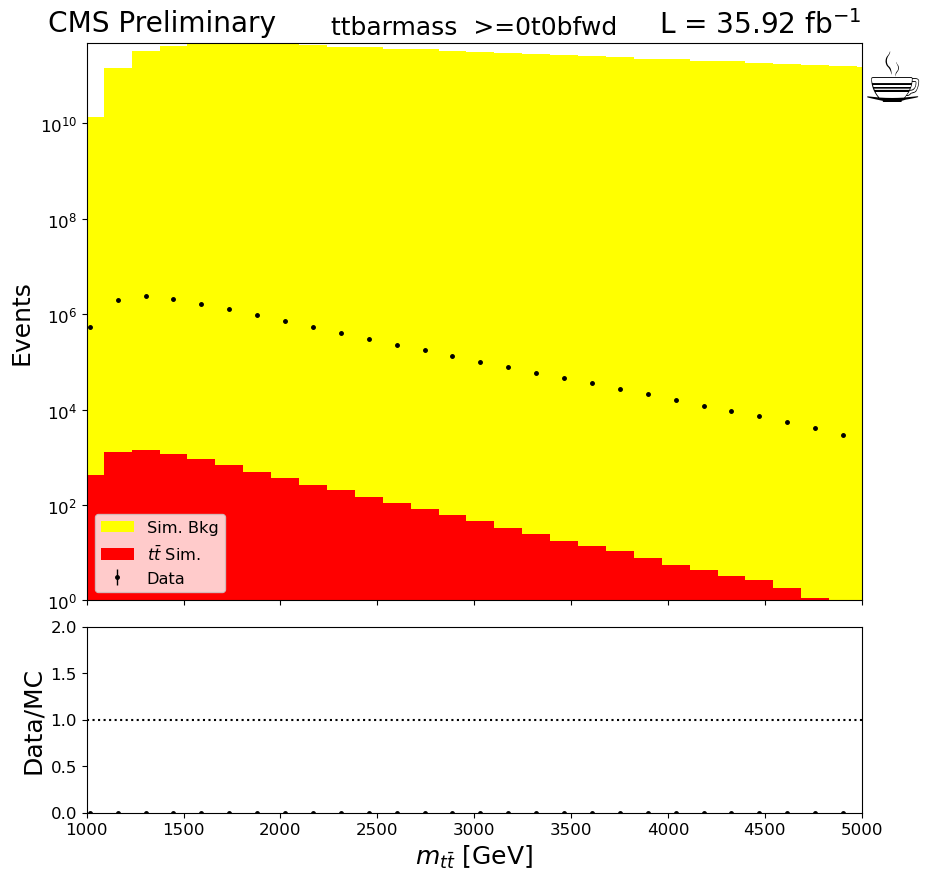

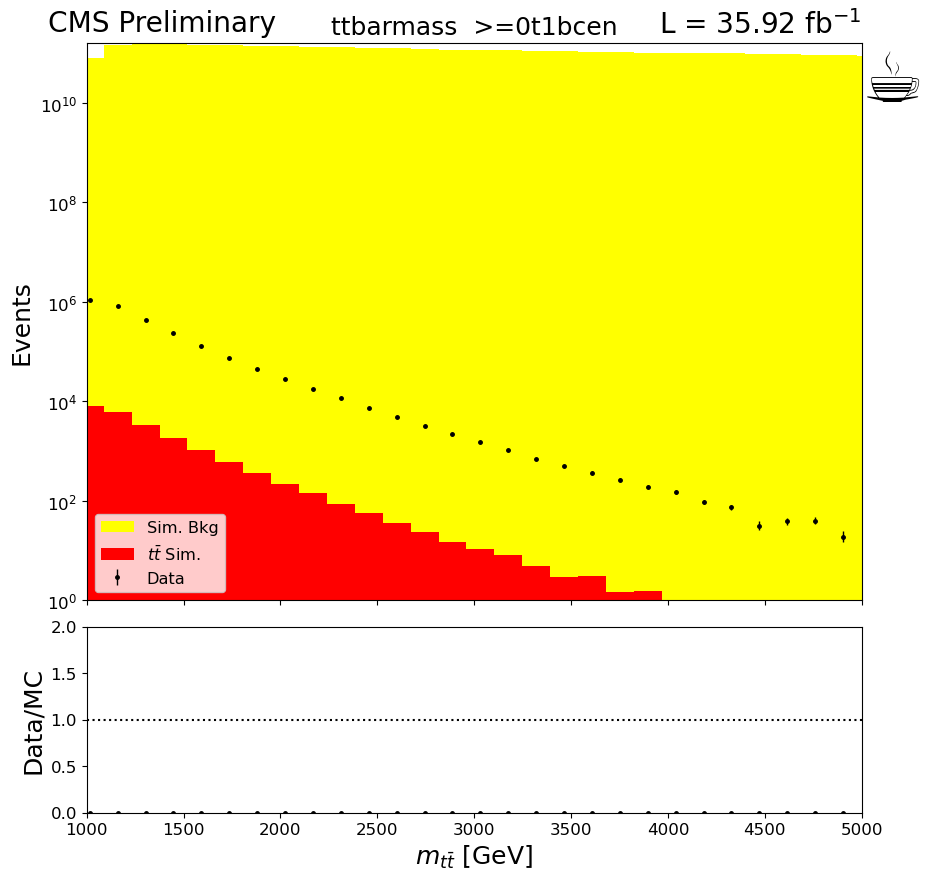

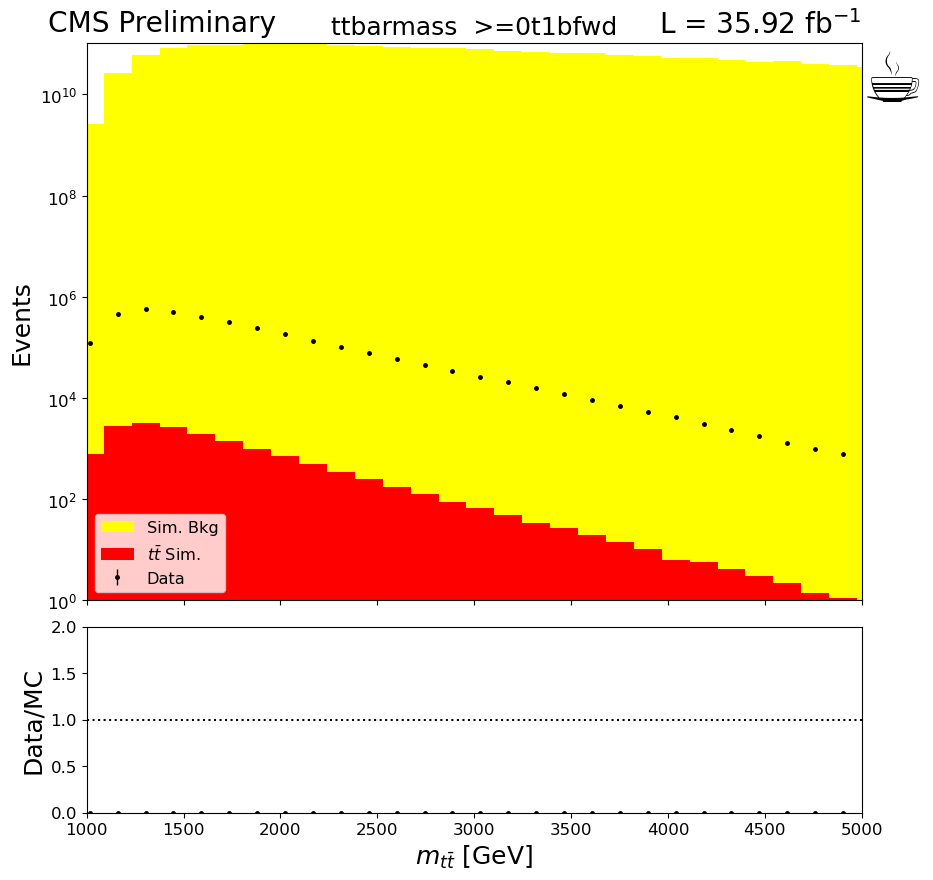

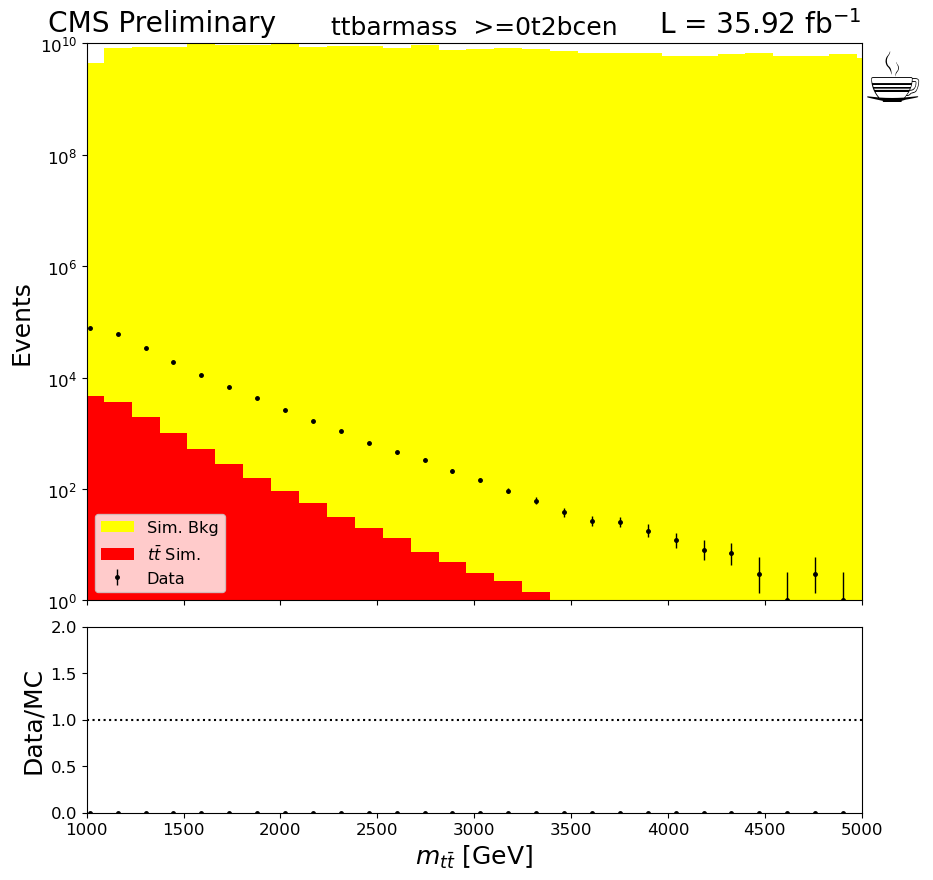

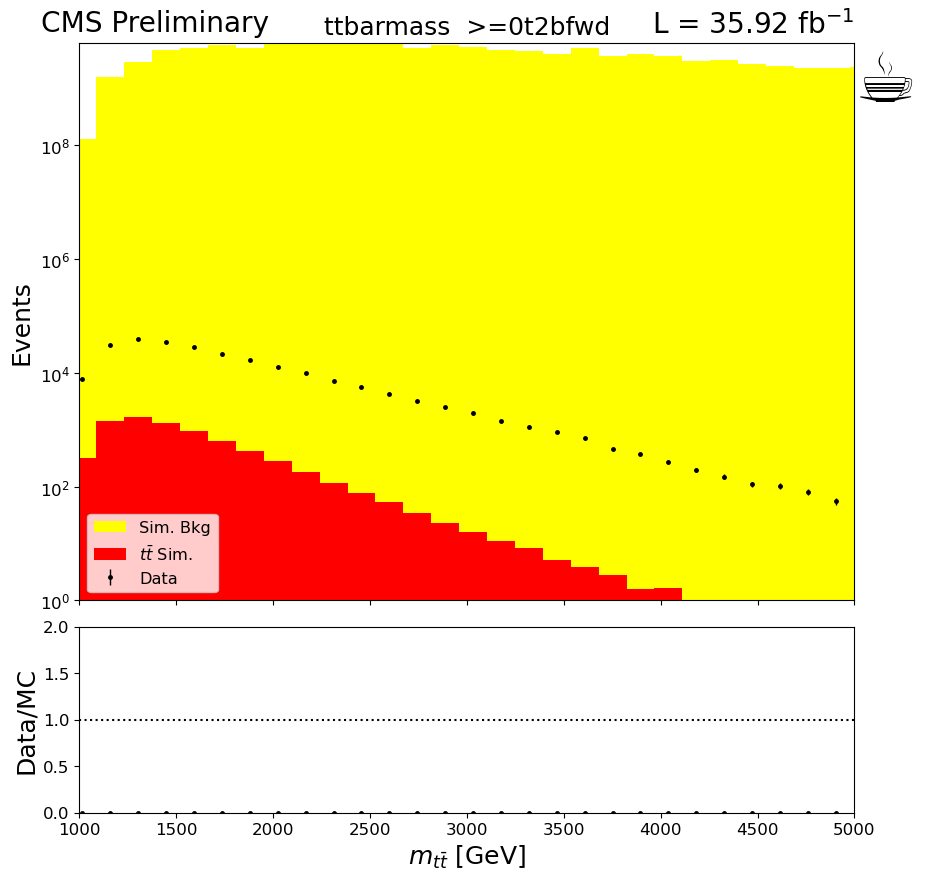

In [10]:
count = 0
# ---- List the Histograms Here ---- #
# list_of_hists_4vector = ['ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'jetmass', 'SDmass', 'tau32']
list_of_hists_4vector = ['ttbarmass']

for ihist in list_of_hists_4vector:
    # -- split histograms into subdirectories -- #
    SaveDirectory = f'{maindirectory}/UnweightedAnalysisPlots/{yeardir}{btagdir}{oddir}{btagType}{ihist}/{PlotType}/'
    hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    for icat, ilabel in label_dict.items(): 
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })
        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(10,10),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        fig.subplots_adjust(hspace=.07)
        title = ihist + '  ' + ilabel
        #filename = ihist + '_' + ilabel + '_LinearScale.' + 'png'
        filename = ihist + '_' + ilabel + '.' + 'png'

        
#    ===================================================================================================================
#    DDDD       A    TTTTTTT    A        H     H IIIIIII   SSSSS TTTTTTT   OOO   GGGGGGG RRRRRR     A    M     M   SSSSS     
#    D   D     A A      T      A A       H     H    I     S         T     O   O  G       R     R   A A   MM   MM  S          
#    D    D   A   A     T     A   A      H     H    I    S          T    O     O G       R     R  A   A  M M M M S           
#    D     D  AAAAA     T     AAAAA      HHHHHHH    I     SSSSS     T    O     O G  GGGG RRRRRR   AAAAA  M  M  M  SSSSS      
#    D    D  A     A    T    A     A     H     H    I          S    T    O     O G     G R   R   A     A M     M       S     
#    D   D   A     A    T    A     A     H     H    I         S     T     O   O  G     G R    R  A     A M     M      S      
#    DDDD    A     A    T    A     A     H     H IIIIIII SSSSS      T      OOO    GGGGG  R     R A     A M     M SSSSS
#    ===================================================================================================================

        
        Data_hist = LD.AddEraHists(JetHT2016_unweighted, 2016, ihist, icat)
           
                    
#    ===================================================================================================
#    N     N   OOO   RRRRRR  M     M    A    L       IIIIIII ZZZZZZZ EEEEEEE       QQQ     CCCC  DDDD        
#    NN    N  O   O  R     R MM   MM   A A   L          I         Z  E            Q   Q   C      D   D       
#    N N   N O     O R     R M M M M  A   A  L          I        Z   E           Q     Q C       D    D      
#    N  N  N O     O RRRRRR  M  M  M  AAAAA  L          I       Z    EEEEEEE     Q     Q C       D     D     
#    N   N N O     O R   R   M     M A     A L          I      Z     E           Q   Q Q C       D    D      
#    N    NN  O   O  R    R  M     M A     A L          I     Z      E            Q   Q   C      D   D       
#    N     N   OOO   R     R M     M A     A LLLLLLL IIIIIII ZZZZZZZ EEEEEEE       QQQ Q   CCCC  DDDD
#    ===================================================================================================

        QCD_hist = QCD2016_unweighted['preVFP'][ihist]['UL16preVFP_QCD', icat, :]*qcd2016_sf['preVFP']\
                 + QCD2016_unweighted['postVFP'][ihist]['UL16postVFP_QCD', icat, :]*qcd2016_sf['postVFP']

#    ===================================================================================================================
#    N     N   OOO   RRRRRR  M     M    A    L       IIIIIII ZZZZZZZ EEEEEEE     TTTTTTT TTTTTTT BBBBBB     A    RRRRRR      
#    NN    N  O   O  R     R MM   MM   A A   L          I         Z  E              T       T    B     B   A A   R     R     
#    N N   N O     O R     R M M M M  A   A  L          I        Z   E              T       T    B     B  A   A  R     R     
#    N  N  N O     O RRRRRR  M  M  M  AAAAA  L          I       Z    EEEEEEE        T       T    BBBBBB   AAAAA  RRRRRR      
#    N   N N O     O R   R   M     M A     A L          I      Z     E              T       T    B     B A     A R   R       
#    N    NN  O   O  R    R  M     M A     A L          I     Z      E              T       T    B     B A     A R    R      
#    N     N   OOO   R     R M     M A     A LLLLLLL IIIIIII ZZZZZZZ EEEEEEE        T       T    BBBBBB  A     A R     R 
#    ===================================================================================================================
        
        TTbar_hist = LM.ScaledTTbar(TTbar2016_unweighted, 2016, ihist, icat, ttbar2016_sf) # SM TTbar MC in Signal Region

#    ===================================================================================================================================
#    N     N   OOO   RRRRRR  M     M    A    L       IIIIIII ZZZZZZZ EEEEEEE     RRRRRR    SSSSS GGGGGGG L       U     U   OOO   N     N     
#    NN    N  O   O  R     R MM   MM   A A   L          I         Z  E           R     R  S      G       L       U     U  O   O  NN    N     
#    N N   N O     O R     R M M M M  A   A  L          I        Z   E           R     R S       G       L       U     U O     O N N   N     
#    N  N  N O     O RRRRRR  M  M  M  AAAAA  L          I       Z    EEEEEEE     RRRRRR   SSSSS  G  GGGG L       U     U O     O N  N  N     
#    N   N N O     O R   R   M     M A     A L          I      Z     E           R   R         S G     G L       U     U O     O N   N N     
#    N    NN  O   O  R    R  M     M A     A L          I     Z      E           R    R       S  G     G L        U   U   O   O  N    NN     
#    N     N   OOO   R     R M     M A     A LLLLLLL IIIIIII ZZZZZZZ EEEEEEE     R     R SSSSS    GGGGG  LLLLLLL   UUU     OOO   N     N 
#    ===================================================================================================================================

        # RSG1000_hist = RSGluon1000_unweighted[ihist]['UL16postVFP_RSGluon1000', icat, :]
        # RSG1000_hist *= RSGluon1000_sf2016 #scaled according to luminosity  
        
#    ===========================================================================================
#    N     N   OOO   RRRRRR  M     M    A    L       IIIIIII ZZZZZZZ EEEEEEE     DDDD    M     M     
#    NN    N  O   O  R     R MM   MM   A A   L          I         Z  E           D   D   MM   MM     
#    N N   N O     O R     R M M M M  A   A  L          I        Z   E           D    D  M M M M     
#    N  N  N O     O RRRRRR  M  M  M  AAAAA  L          I       Z    EEEEEEE     D     D M  M  M     
#    N   N N O     O R   R   M     M A     A L          I      Z     E           D    D  M     M     
#    N    NN  O   O  R    R  M     M A     A L          I     Z      E           D   D   M     M     
#    N     N   OOO   R     R M     M A     A LLLLLLL IIIIIII ZZZZZZZ EEEEEEE     DDDD    M     M
#    ===========================================================================================
        
        # DM1000_hist = DM1000_unweighted[ihist]['UL16postVFP_DM1000', icat, :]
        # DM1000_hist *= DM1000_sf2016 #scaled according to luminosity
            
#    ===========================================================================
#    M     M    A    K     K EEEEEEE     PPPPPP  L         OOO   TTTTTTT   SSSSS     
#    MM   MM   A A   K   K   E           P     P L        O   O     T     S          
#    M M M M  A   A  K K     E           P     P L       O     O    T    S           
#    M  M  M  AAAAA  KKk     EEEEEEE     PPPPPP  L       O     O    T     SSSSS      
#    M     M A     A K  K    E           P       L       O     O    T          S     
#    M     M A     A K   K   E           P       L        O   O     T         S      
#    M     M A     A K   K   EEEEEEE     P       LLLLLLL   OOO      T    SSSSS 
#    ===========================================================================

        MC_hist = TTbar_hist.copy()
        MC_hist += QCD_hist
        
        # ---- Extract both the data and MC events and from histograms ---- #
        NtotalMC = np.sum(MC_hist.view().value)
        NtotalData = np.sum(Data_hist.view().value)
        
        # ---- Normalize the total MC histogram directly to the data (for aesthetic purposes only!) ---- #
        # -------- Unweighted simulation of the background alone greatly overestimates ------- #
#         if NtotalMC > 0.:
#             MC_hist *= (NtotalData/NtotalMC)
#             TTbar_hist *= (NtotalData/NtotalMC)
#         else:
#             MC_hist *= 0.
#             TTbar_hist *= 0.
        
#         if ilabel == '0t0bcen' or ilabel == '0t1bcen':
#             print(f'{ilabel} category bins: ', QCD_hist.view().variance)
        
        #---- Plot Data ----#
        #-----------------------------------------------------------------#
        Data_hist.plot1d(ax=ax, histtype='errorbar', marker='.', markersize=5., color='k')
        
        #---- Plot Total MC (simulated QCD + SM ttbar background)----#
        #-----------------------------------------------------------------#
        MC_hist.plot1d(ax=ax, histtype='fill', color='yellow')
        
        #---- Plot TTbar MC for comparison ---- #
        #-----------------------------------------------------------------#    
        TTbar_hist.plot1d(ax=ax, histtype='fill', color='red')
        
        #---- Plot RSG MC for comparison ---- #
        #-----------------------------------------------------------------#   
        # RSG1000_hist.plot1d(ax=ax, histtype='step', color='purple')
        
        
        #---- Plot DMM MC for comparison ----#
        #-----------------------------------------------------------------#
        # DM1000_hist.plot1d(ax=ax, histtype='step', color='black')
        
        if count > 0:
            filler = 'a'
        if count < 6 and icat in range(36,42): # Print number of events for each category once
            with open(DataOutName, filler) as f:
                NtotalTT = np.sum(TTbar_hist.view().value)
                print(f'\t\t{ilabel}\n===================================================', file=f)
                print('Observed Data Events   = ', '%10i'% NtotalData, file=f)
                print('Simulated TTbar Events = ', '%10i'% NtotalTT,   file=f)
                print()
                count += 1
            
        # if icat in range(18,30) or icat in range(36,42):
        #     filename = 'AnalysisCategories/' + ihist + '_' + ilabel + '.' + 'png'
        #     hpdDoesDirectoryExist(SaveDirectory+'AnalysisCategories/') # no need to create the directory several times if it exists already
        
        plt.autoscale(enable=True, axis='y')
        ax.set_ylim(bottom=1.)
        ax.set_yscale(PlotType)
        ax.set_ylabel('Events')
        ax.set_xlabel(None)
        ax.set_title(title)
        # leg = ax.legend(labels=[r'Sim. Bkg', r'$t\bar{t}$ Sim.', r'RSKK Gluon $1TeV$ Sim.', r'DM Med. $1TeV$ Sim.', r'Data'], fontsize='xx-small')
        leg = ax.legend(labels=[r'Sim. Bkg', r'$t\bar{t}$ Sim.', r'Data'], fontsize='small')
        
        
        #---- Plot Ratio ----#
        # hpd.plotratio(QCD_hist, Background, ax = rax, histtype='errorbar', marker='.', markersize=4., color='k')
        hpd.plotratio(Data_hist, MC_hist, ax = rax, histtype = 'errorbar')
        rax.set_ylabel('Data/MC')
        rax.axhline(y=1, color='k', linestyle=':')
        rax.set_ylim(0,2)
        
        if ihist == 'ttbarmass':
            rax.set_xlim(1000,5000)
        if ihist == 'jetpt':
            rax.set_xlim(400,2000)
        if ihist == 'jeteta':
            rax.set_xlim(-3,3)
        if ihist == 'tau32':
            rax.set_xlim(0,1.2)
        
        #---- Labeling ----#
        Lint = str(Lum2016*.001) # Integrated Luminosity
        lumi = plt.text(1.0, 1.06, "L = " + Lint[:6] + " fb$^{-1}$",
                fontsize='x-large',
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes
               )
        CMS = plt.text(-0.05, 1.06, 'CMS Preliminary',
                fontsize='x-large',
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes
               )
        coffee = plt.text(1.0, 0.87, u"☕",
                      fontsize=50,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes
                     )
        if saveOn:
            if icat in range(18,30) or icat in range(36,42):
                filename = 'AnalysisCategories/' + ihist + '_' + ilabel + '.' + 'png'
                hpd.DoesDirectoryExist(SaveDirectory+'AnalysisCategories/') # no need to create the directory several times if it exists already
            plt.savefig(SaveDirectory+filename, bbox_inches="tight")
            print(SaveDirectory+filename)

# 1D Discriminator Plots

In [11]:
PlotType = 'linear'
saveOn = False

In [12]:
UnscaledTT = {}
for vfp in ['preVFP', 'postVFP']:
    UnscaledTT[f'700_1000_{vfp}'] = 1.0
    UnscaledTT[f'1000_Inf_{vfp}'] = 1.0

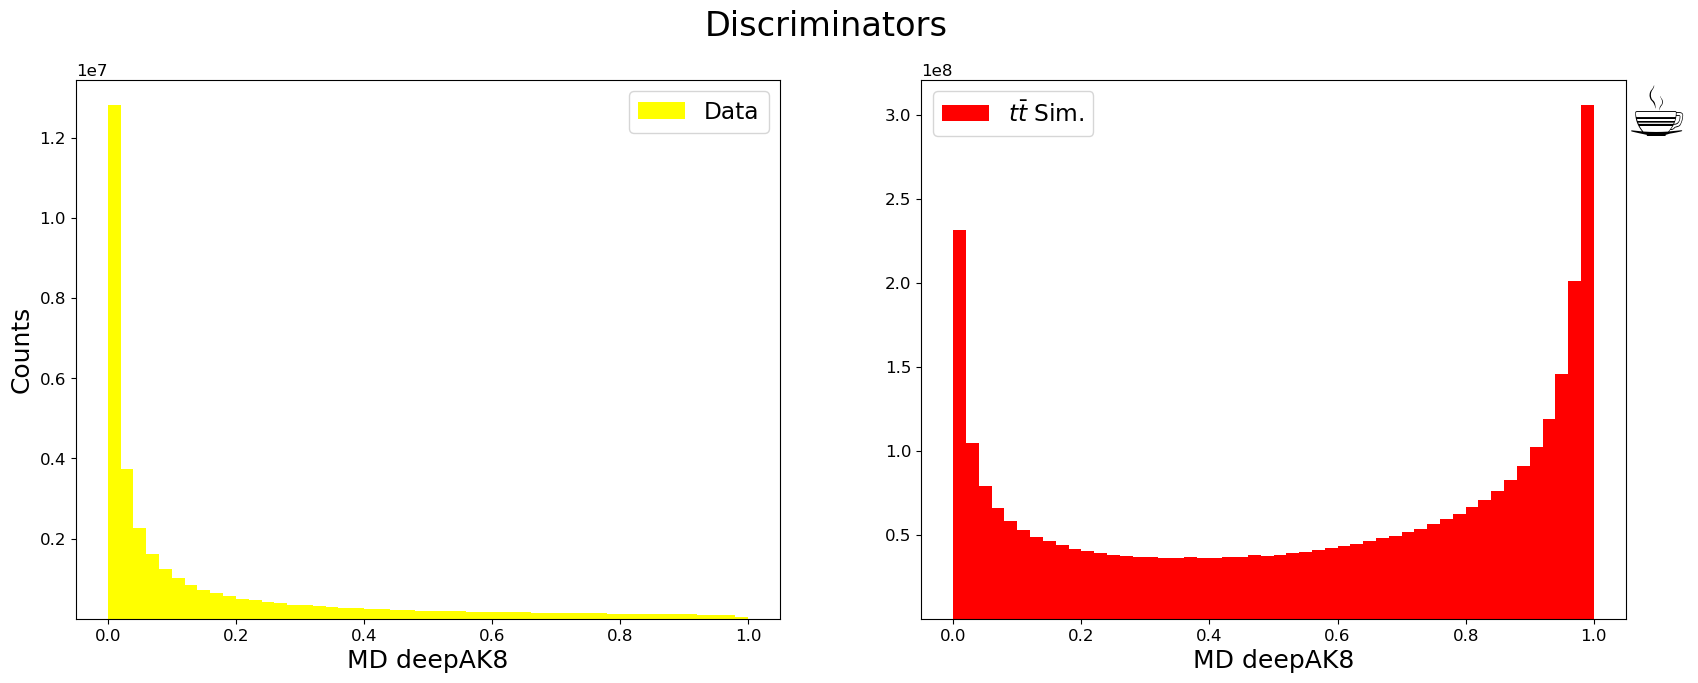

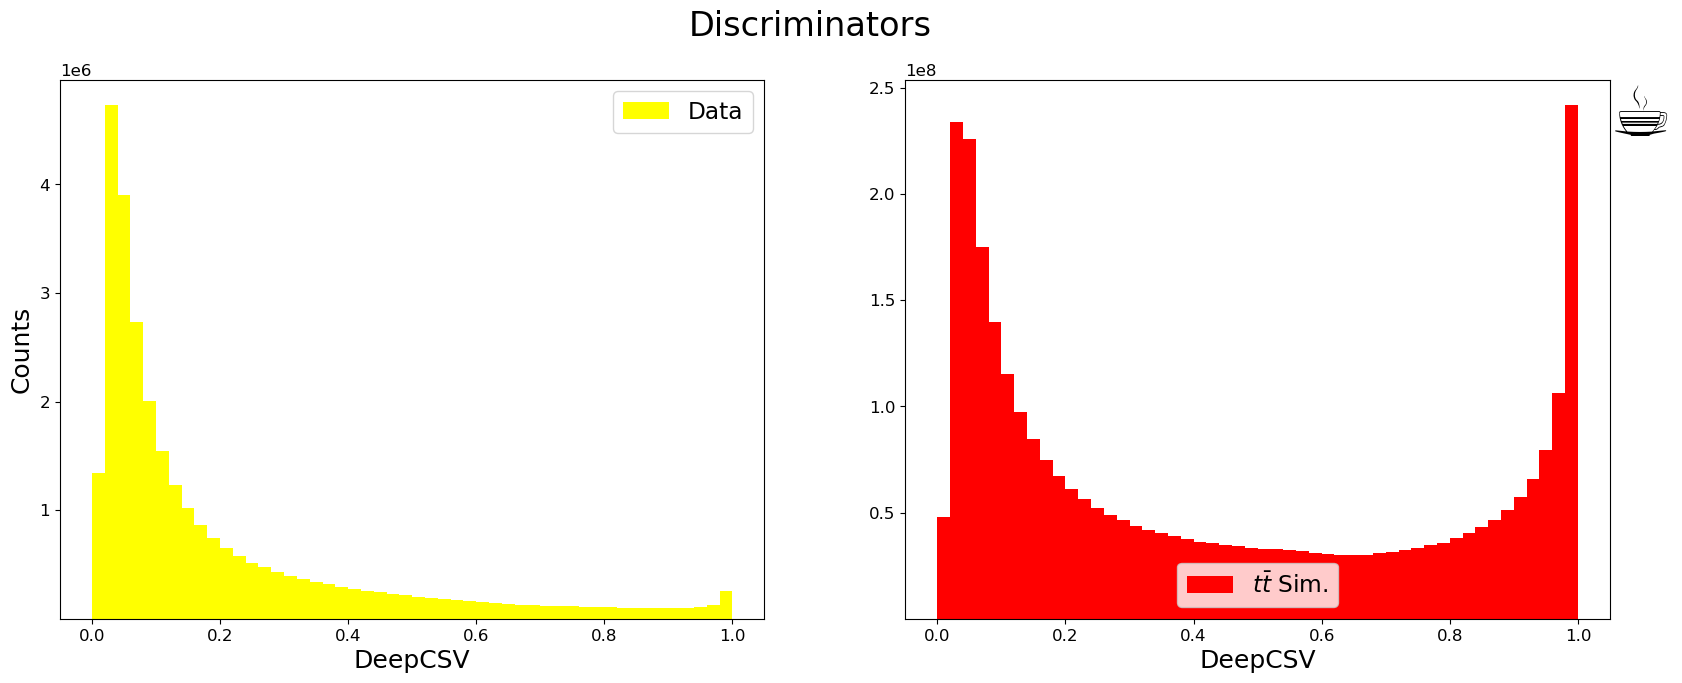

In [13]:
# ---- List the Histograms Here ---- #
list_of_hists_4vector = ['deepTagMD_TvsQCD', 'deepB_fatjet']

for ihist in list_of_hists_4vector:
    # -- split histograms into subdirectories -- #
    # SaveDirectory = f'{maindirectory}/UnweightedAnalysisPlots/{yeardir}{btagdir}{oddir}{btagType}{ihist}/{PlotType}/'
    SaveDirectory = f'{maindirectory}/DiscriminatorPlots/{yeardir}{btagdir}{oddir}{btagType}'
    hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
     
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (axData, axTTbar) = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(20,7),
        # gridspec_kw={"height_ratios": (3, 1)},
        # sharex=True
    )
    
    fig.subplots_adjust(hspace=.07)
    filename = ihist + '_1D_' + PlotType + '.png'
    fig.suptitle('Discriminators', fontsize='xx-large')

    Data_hist = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '')
    TTbar_hist = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT)


#    ===========================================================================
#    M     M    A    K     K EEEEEEE     PPPPPP  L         OOO   TTTTTTT   SSSSS     
#    MM   MM   A A   K   K   E           P     P L        O   O     T     S          
#    M M M M  A   A  K K     E           P     P L       O     O    T    S           
#    M  M  M  AAAAA  KKk     EEEEEEE     PPPPPP  L       O     O    T     SSSSS      
#    M     M A     A K  K    E           P       L       O     O    T          S     
#    M     M A     A K   K   E           P       L        O   O     T         S      
#    M     M A     A K   K   EEEEEEE     P       LLLLLLL   OOO      T    SSSSS 
#    ===========================================================================

    #---- Plot Data ----#
    #-----------------------------------------------------------------#
    Data_hist.plot1d(ax=axData, histtype='fill', color='yellow')
    TTbar_hist.plot1d(ax=axTTbar, histtype='fill', color='red')
    
    plt.autoscale(enable=True, axis='y')
    axData.set_ylim(bottom=1.)
    axData.set_yscale(PlotType)
    axTTbar.set_ylim(bottom=1.)
    axTTbar.set_yscale(PlotType)
    axData.set_ylabel('Counts')
    
    legData = axData.legend(labels=[r'Data'], fontsize='large')
    legTTbar = axTTbar.legend(labels=[r'$t\bar{t}$ Sim.'], fontsize='large')

    #---- Labeling ----#
    # Lint = str(Lum2016*.001) # Integrated Luminosity
    # lumi = plt.text(1.0, 1.06, "L = " + Lint[:6] + " fb$^{-1}$",
    #         fontsize='x-large',
    #         horizontalalignment='right',
    #         verticalalignment='top',
    #         transform=axTTbar.transAxes
    #        )
    # CMS = plt.text(-0.05, 1.06, 'CMS Preliminary',
    #         fontsize='x-large',
    #         horizontalalignment='left',
    #         verticalalignment='top',
    #         transform=axData.transAxes
    #        )
    coffee = plt.text(1.0, 0.87, u"☕",
                  fontsize=50,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=axTTbar.transAxes
                 )
    if saveOn:
        plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        print(SaveDirectory+filename)

# 1D Discriminator Plots in Mass Ranges 

In [14]:
PlotType = 'log'
saveOn = False

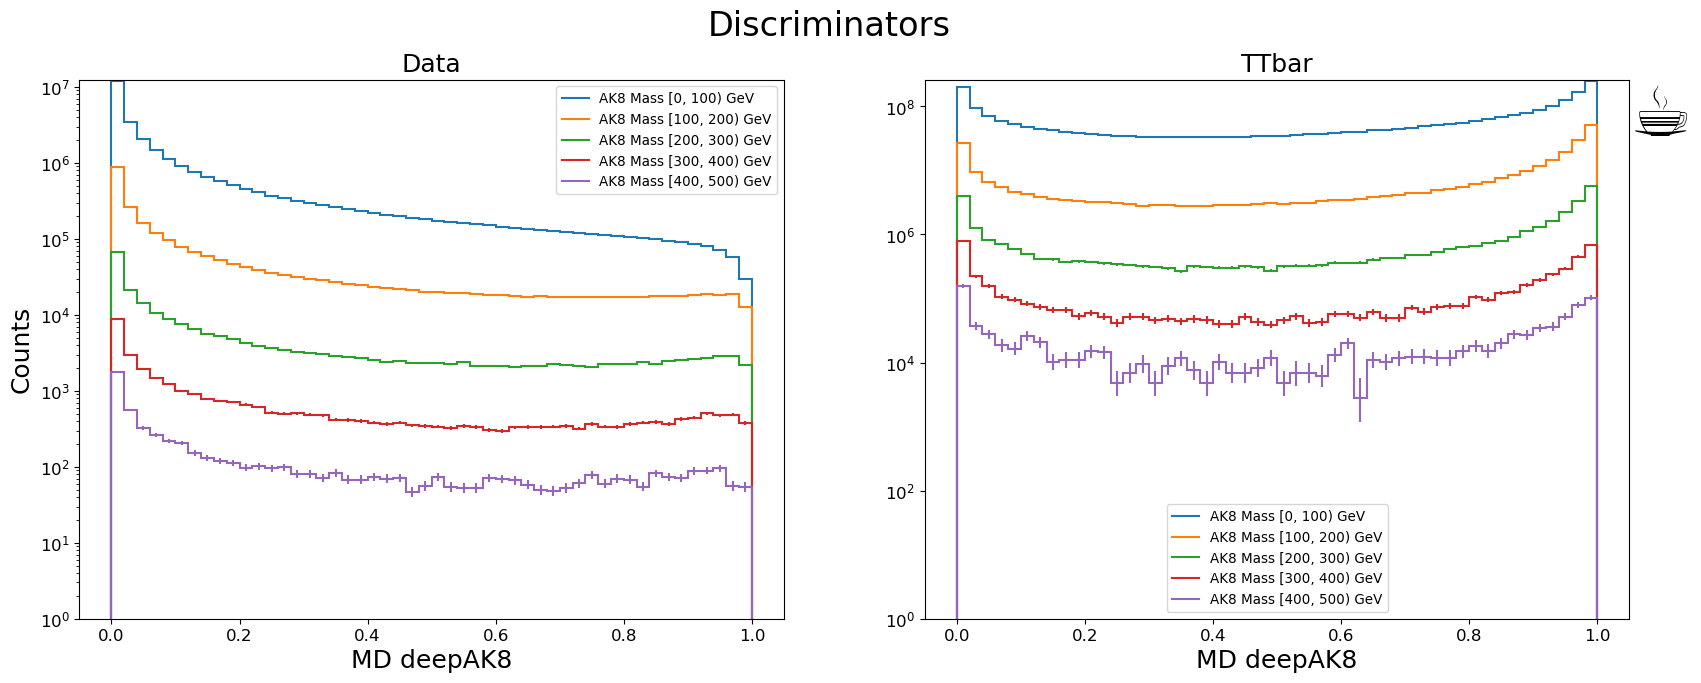

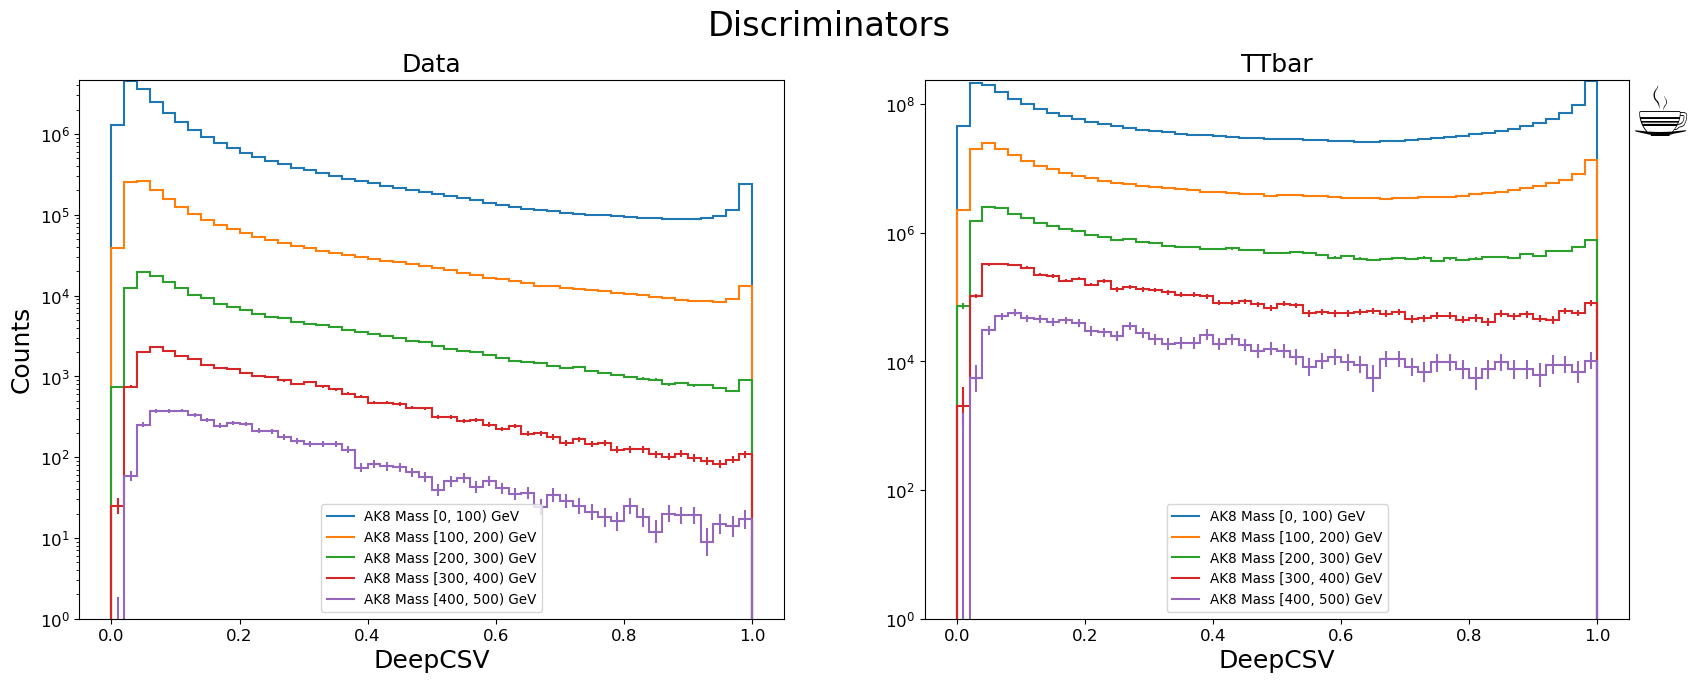

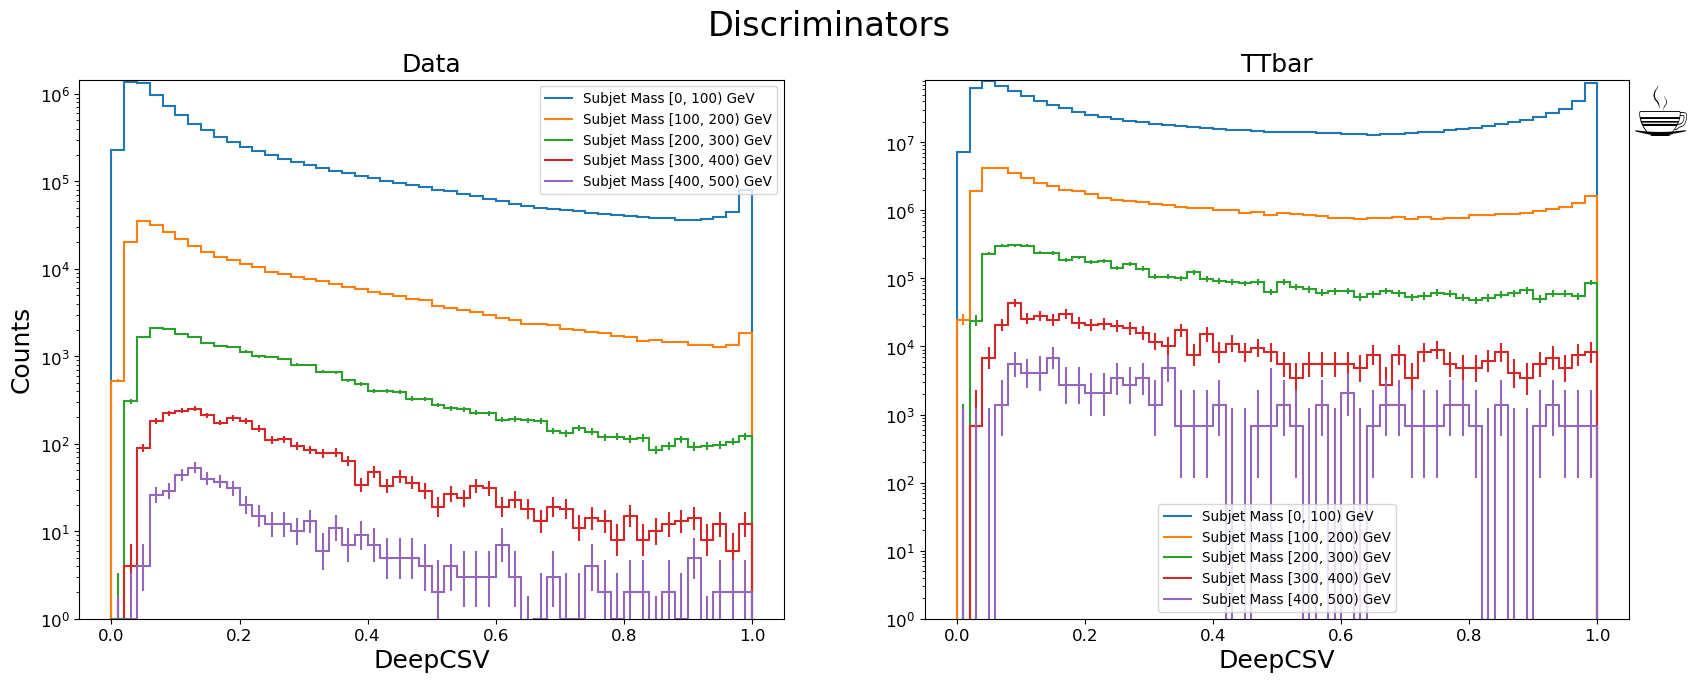

In [15]:
# ---- List the Histograms Here ---- #
list_of_hists_4vector = ['deepTagMD_TvsQCD', 'deepB_fatjet', 'deepB_subjet']

for ihist in list_of_hists_4vector:
    # -- split histograms into subdirectories -- #
    # SaveDirectory = f'{maindirectory}/UnweightedAnalysisPlots/{yeardir}{btagdir}{oddir}{btagType}{ihist}/{PlotType}/'
    SaveDirectory = f'{maindirectory}/DiscriminatorPlots/{yeardir}{btagdir}{oddir}{btagType}'
    hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
     
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (axData, axTTbar) = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(20,7),
        # gridspec_kw={"height_ratios": (3, 1)},
        # sharex=True
    )
    
    fig.subplots_adjust(hspace=.07)
    filename = ihist + '_1D_MassWindows.png'
    fig.suptitle('Discriminators', fontsize='xx-large')
    
    # ---- starting bins ---- #
    Data_hist_0_100   = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', massbin=0)
    Data_hist_100_200 = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', massbin=10)
    Data_hist_200_300 = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', massbin=20)
    Data_hist_300_400 = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', massbin=30)
    Data_hist_400_500 = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', massbin=40)
    
    TTbar_hist_0_100   = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, massbin=0)
    TTbar_hist_100_200 = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, massbin=10)
    TTbar_hist_200_300 = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, massbin=20)
    TTbar_hist_300_400 = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, massbin=30)
    TTbar_hist_400_500 = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, massbin=40)
    
    for i in range(1,10):
        Data_hist_0_100   += LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', massbin=i)
        Data_hist_100_200 += LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', massbin=10+i)
        Data_hist_200_300 += LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', massbin=20+i)
        Data_hist_300_400 += LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', massbin=30+i)
        Data_hist_400_500 += LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', massbin=40+i)

        TTbar_hist_0_100   += LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, massbin=i)
        TTbar_hist_100_200 += LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, massbin=10+i)
        TTbar_hist_200_300 += LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, massbin=20+i)
        TTbar_hist_300_400 += LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, massbin=30+i)
        TTbar_hist_400_500 += LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, massbin=40+i)


#    ===========================================================================
#    M     M    A    K     K EEEEEEE     PPPPPP  L         OOO   TTTTTTT   SSSSS     
#    MM   MM   A A   K   K   E           P     P L        O   O     T     S          
#    M M M M  A   A  K K     E           P     P L       O     O    T    S           
#    M  M  M  AAAAA  KKk     EEEEEEE     PPPPPP  L       O     O    T     SSSSS      
#    M     M A     A K  K    E           P       L       O     O    T          S     
#    M     M A     A K   K   E           P       L        O   O     T         S      
#    M     M A     A K   K   EEEEEEE     P       LLLLLLL   OOO      T    SSSSS 
#    ===========================================================================

    #---- Plot Data ----#
    #-----------------------------------------------------------------#
    Data_hist_0_100.plot1d(ax=axData, histtype='step')
    Data_hist_100_200.plot1d(ax=axData, histtype='step')
    Data_hist_200_300.plot1d(ax=axData, histtype='step')
    Data_hist_300_400.plot1d(ax=axData, histtype='step')
    Data_hist_400_500.plot1d(ax=axData, histtype='step')
    
    TTbar_hist_0_100.plot1d(ax=axTTbar, histtype='step')
    TTbar_hist_100_200.plot1d(ax=axTTbar, histtype='step')
    TTbar_hist_200_300.plot1d(ax=axTTbar, histtype='step')
    TTbar_hist_300_400.plot1d(ax=axTTbar, histtype='step')
    TTbar_hist_400_500.plot1d(ax=axTTbar, histtype='step')
    
    plt.autoscale(enable=True, axis='y')
    axData.set_ylim(bottom=1.)
    axData.set_yscale(PlotType)
    axData.set_title('Data')
    axTTbar.set_ylim(bottom=1.)
    axTTbar.set_yscale(PlotType)
    axTTbar.set_title('TTbar')
    axData.set_ylabel('Counts')
    
    legData = axData.legend(labels=[r'AK8 Mass [0, 100) GeV', 
                                    r'AK8 Mass [100, 200) GeV', 
                                    r'AK8 Mass [200, 300) GeV', 
                                    r'AK8 Mass [300, 400) GeV', 
                                    r'AK8 Mass [400, 500) GeV'], fontsize='x-small')
    legTTbar = axTTbar.legend(labels=[r'AK8 Mass [0, 100) GeV', 
                                      r'AK8 Mass [100, 200) GeV', 
                                      r'AK8 Mass [200, 300) GeV', 
                                      r'AK8 Mass [300, 400) GeV', 
                                      r'AK8 Mass [400, 500) GeV'], fontsize='x-small')
    
    if 'subjet' in ihist:
        
        legData = axData.legend(labels=[r'Subjet Mass [0, 100) GeV', 
                                        r'Subjet Mass [100, 200) GeV', 
                                        r'Subjet Mass [200, 300) GeV', 
                                        r'Subjet Mass [300, 400) GeV', 
                                        r'Subjet Mass [400, 500) GeV'], fontsize='x-small')
        legTTbar = axTTbar.legend(labels=[r'Subjet Mass [0, 100) GeV', 
                                          r'Subjet Mass [100, 200) GeV', 
                                          r'Subjet Mass [200, 300) GeV', 
                                          r'Subjet Mass [300, 400) GeV', 
                                          r'Subjet Mass [400, 500) GeV'], fontsize='x-small')

    
    coffee = plt.text(1.0, 0.87, u"☕",
                  fontsize=50,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=axTTbar.transAxes
                 )
    if saveOn:
        plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        print(SaveDirectory+filename)

# 1D Discriminator Plots in $P_T$ Ranges 

In [16]:
PlotType = 'log'
saveOn = False

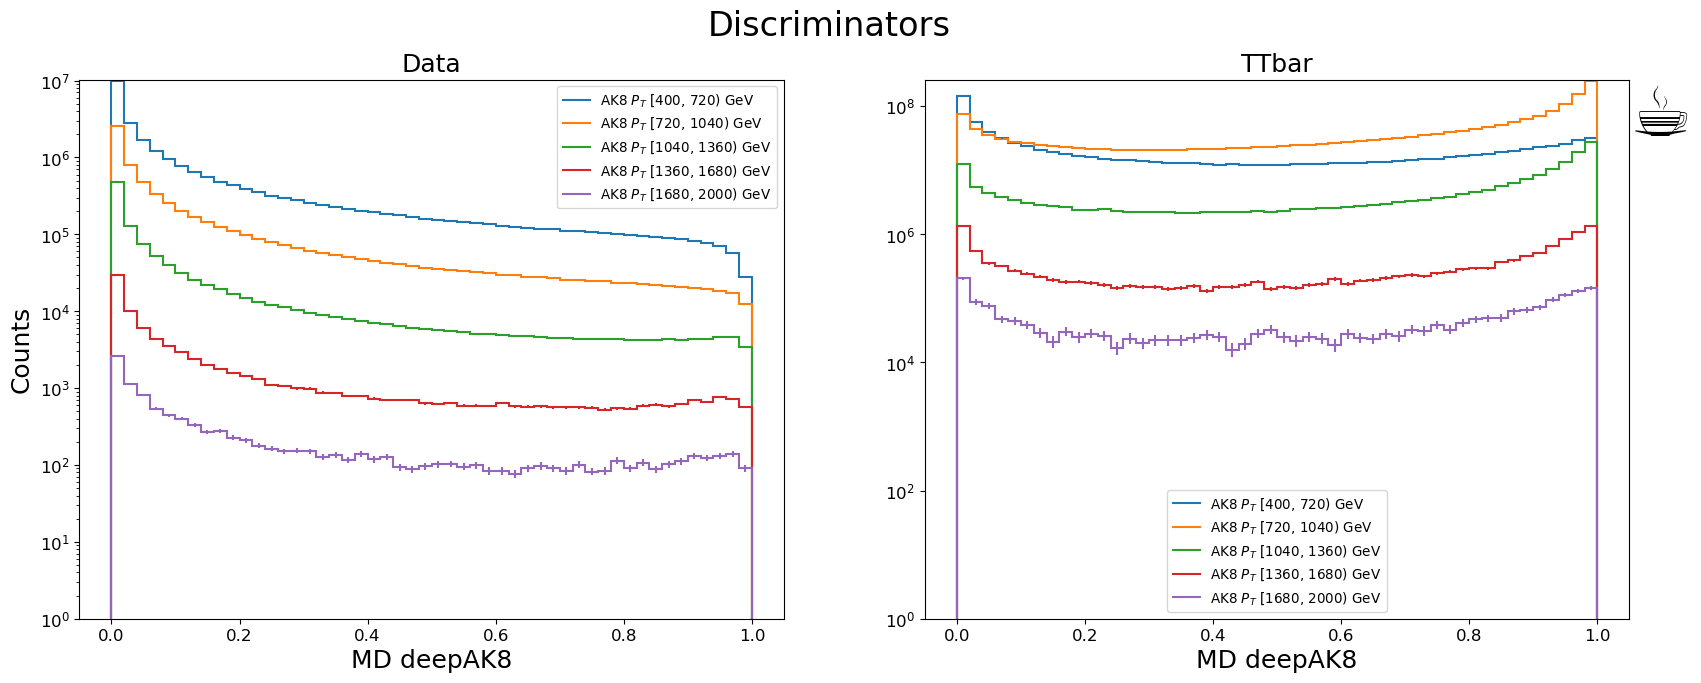

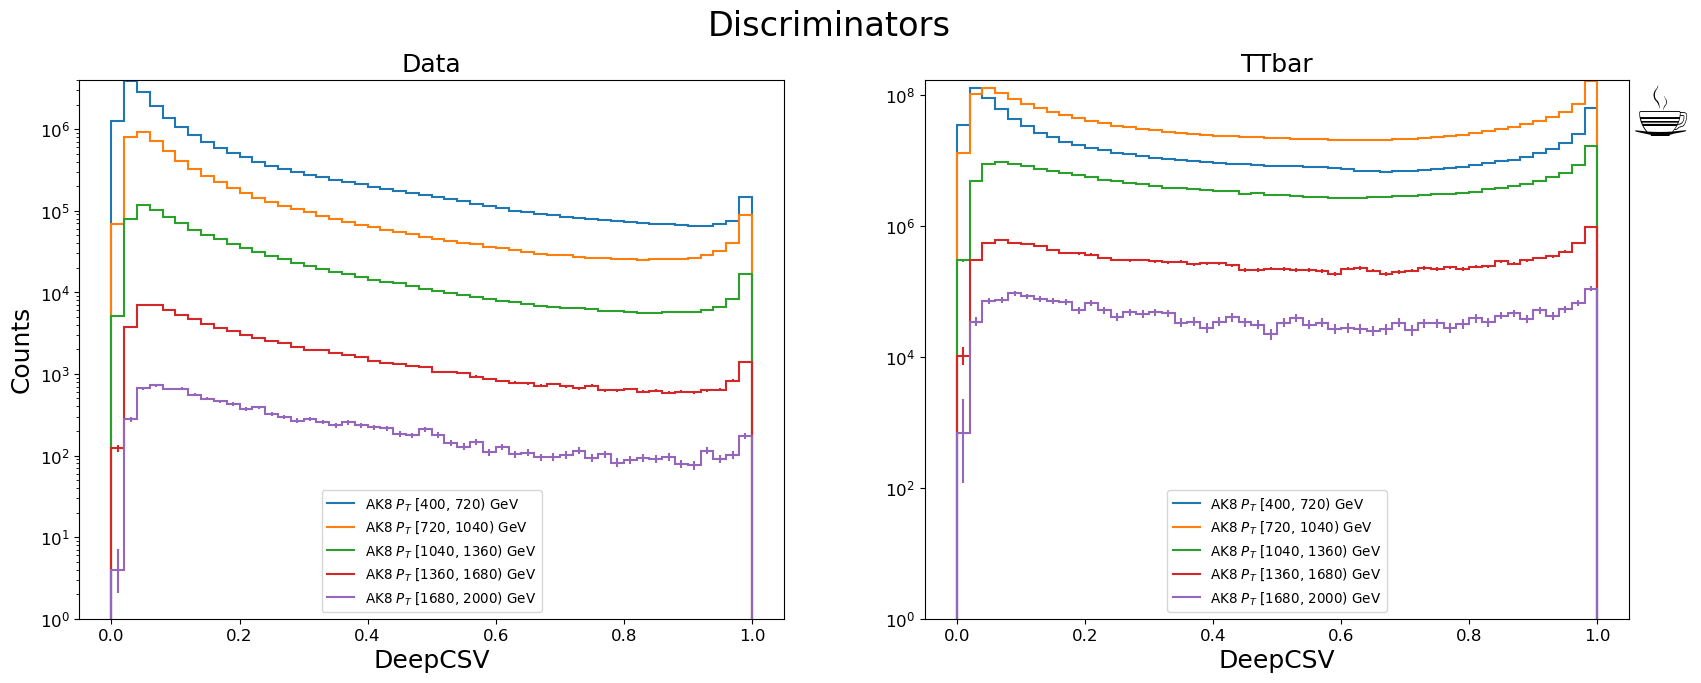

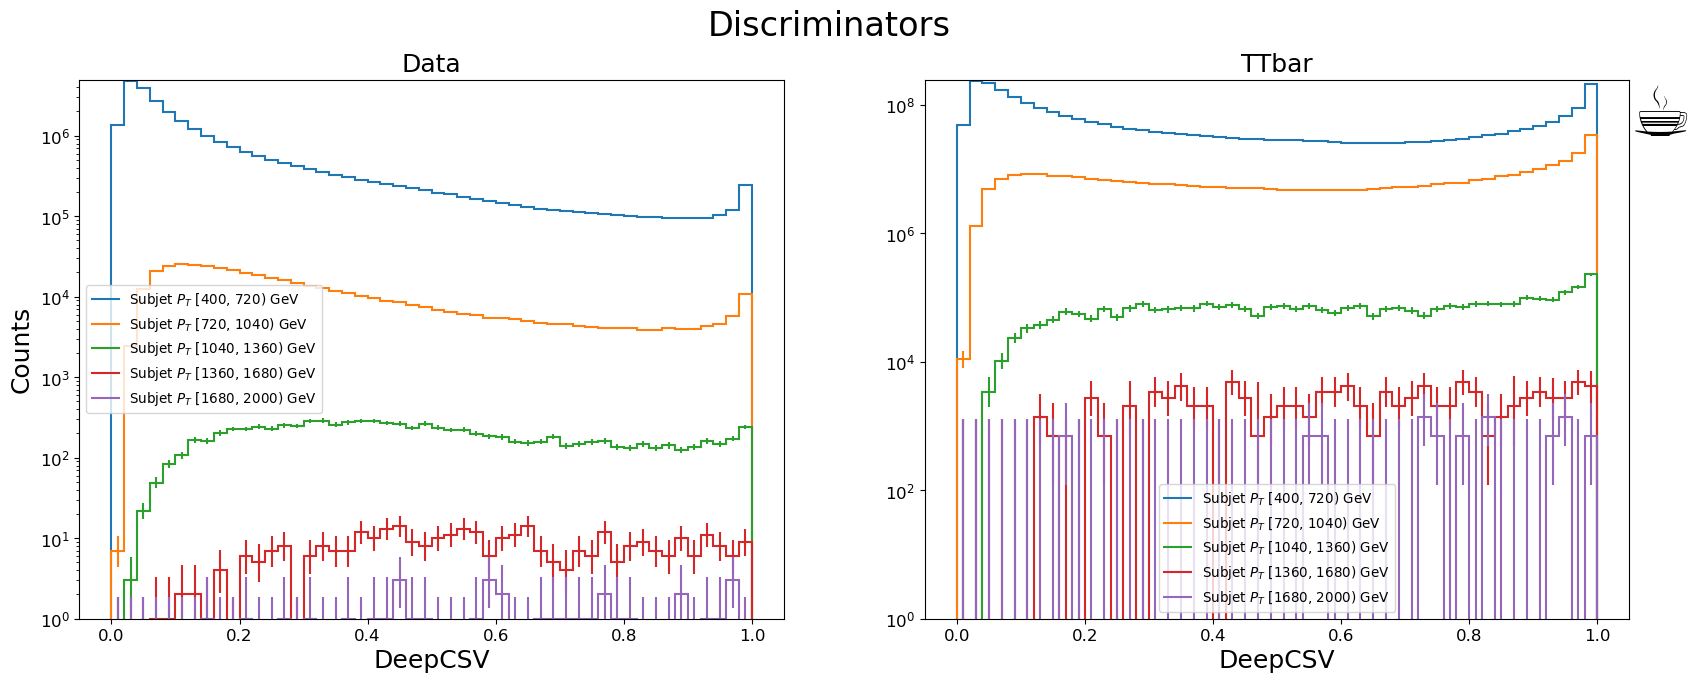

In [17]:
# ---- List the Histograms Here ---- #
list_of_hists_4vector = ['deepTagMD_TvsQCD', 'deepB_fatjet', 'deepB_subjet']

for ihist in list_of_hists_4vector:
    # -- split histograms into subdirectories -- #
    # SaveDirectory = f'{maindirectory}/UnweightedAnalysisPlots/{yeardir}{btagdir}{oddir}{btagType}{ihist}/{PlotType}/'
    SaveDirectory = f'{maindirectory}/DiscriminatorPlots/{yeardir}{btagdir}{oddir}{btagType}'
    hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
     
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (axData, axTTbar) = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(20,7),
        # gridspec_kw={"height_ratios": (3, 1)},
        # sharex=True
    )
    
    fig.subplots_adjust(hspace=.07)
    filename = ihist + '_1D_PtWindows.png'
    fig.suptitle('Discriminators', fontsize='xx-large')
    
    # ---- starting bins ---- #
    Data_hist_400_720   = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', ptbin=0)
    Data_hist_720_1040  = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', ptbin=10)
    Data_hist_1040_1360 = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', ptbin=20)
    Data_hist_1360_1680 = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', ptbin=30)
    Data_hist_1680_2000 = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', ptbin=40)
    
    TTbar_hist_400_720   = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, ptbin=0)
    TTbar_hist_720_1040  = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, ptbin=10)
    TTbar_hist_1040_1360 = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, ptbin=20)
    TTbar_hist_1360_1680 = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, ptbin=30)
    TTbar_hist_1680_2000 = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, ptbin=40)
    
    for i in range(1,10):
        Data_hist_400_720   += LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', ptbin=i)
        Data_hist_720_1040  += LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', ptbin=10+i)
        Data_hist_1040_1360 += LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', ptbin=20+i)
        Data_hist_1360_1680 += LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', ptbin=30+i)
        Data_hist_1680_2000 += LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, '', ptbin=40+i)

        TTbar_hist_400_720   += LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, ptbin=i)
        TTbar_hist_720_1040  += LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, ptbin=10+i)
        TTbar_hist_1040_1360 += LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, ptbin=20+i)
        TTbar_hist_1360_1680 += LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, ptbin=30+i)
        TTbar_hist_1680_2000 += LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, '', UnscaledTT, ptbin=40+i)


#    ===========================================================================
#    M     M    A    K     K EEEEEEE     PPPPPP  L         OOO   TTTTTTT   SSSSS     
#    MM   MM   A A   K   K   E           P     P L        O   O     T     S          
#    M M M M  A   A  K K     E           P     P L       O     O    T    S           
#    M  M  M  AAAAA  KKk     EEEEEEE     PPPPPP  L       O     O    T     SSSSS      
#    M     M A     A K  K    E           P       L       O     O    T          S     
#    M     M A     A K   K   E           P       L        O   O     T         S      
#    M     M A     A K   K   EEEEEEE     P       LLLLLLL   OOO      T    SSSSS 
#    ===========================================================================

    #---- Plot Data ----#
    #-----------------------------------------------------------------#
    Data_hist_400_720.plot1d(ax=axData, histtype='step')
    Data_hist_720_1040.plot1d(ax=axData, histtype='step')
    Data_hist_1040_1360.plot1d(ax=axData, histtype='step')
    Data_hist_1360_1680.plot1d(ax=axData, histtype='step')
    Data_hist_1680_2000.plot1d(ax=axData, histtype='step')
    
    TTbar_hist_400_720.plot1d(ax=axTTbar, histtype='step')
    TTbar_hist_720_1040.plot1d(ax=axTTbar, histtype='step')
    TTbar_hist_1040_1360.plot1d(ax=axTTbar, histtype='step')
    TTbar_hist_1360_1680.plot1d(ax=axTTbar, histtype='step')
    TTbar_hist_1680_2000.plot1d(ax=axTTbar, histtype='step')
    
    plt.autoscale(enable=True, axis='y')
    axData.set_ylim(bottom=1.)
    axData.set_yscale(PlotType)
    axData.set_title('Data')
    axTTbar.set_ylim(bottom=1.)
    axTTbar.set_yscale(PlotType)
    axTTbar.set_title('TTbar')
    axData.set_ylabel('Counts')
    
    legData = axData.legend(labels=[r'AK8 $P_T$ [400, 720) GeV', 
                                    r'AK8 $P_T$ [720, 1040) GeV', 
                                    r'AK8 $P_T$ [1040, 1360) GeV', 
                                    r'AK8 $P_T$ [1360, 1680) GeV', 
                                    r'AK8 $P_T$ [1680, 2000) GeV'], fontsize='x-small')
    legTTbar = axTTbar.legend(labels=[r'AK8 $P_T$ [400, 720) GeV', 
                                    r'AK8 $P_T$ [720, 1040) GeV', 
                                    r'AK8 $P_T$ [1040, 1360) GeV', 
                                    r'AK8 $P_T$ [1360, 1680) GeV', 
                                    r'AK8 $P_T$ [1680, 2000) GeV'], fontsize='x-small')
    
    if 'subjet' in ihist:
        
        legData = axData.legend(labels=[r'Subjet $P_T$ [400, 720) GeV', 
                                        r'Subjet $P_T$ [720, 1040) GeV', 
                                        r'Subjet $P_T$ [1040, 1360) GeV', 
                                        r'Subjet $P_T$ [1360, 1680) GeV', 
                                        r'Subjet $P_T$ [1680, 2000) GeV'], fontsize='x-small')
        legTTbar = axTTbar.legend(labels=[r'Subjet $P_T$ [400, 720) GeV', 
                                        r'Subjet $P_T$ [720, 1040) GeV', 
                                        r'Subjet $P_T$ [1040, 1360) GeV', 
                                        r'Subjet $P_T$ [1360, 1680) GeV', 
                                        r'Subjet $P_T$ [1680, 2000) GeV'], fontsize='x-small')

    
    coffee = plt.text(1.0, 0.87, u"☕",
                  fontsize=50,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=axTTbar.transAxes
                 )
    if saveOn:
        plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        print(SaveDirectory+filename)

# 2D Discriminator Plots

In [18]:
xaxis = 'pt'
saveOn = False

In [19]:
UnscaledTT = {}
for vfp in ['preVFP', 'postVFP']:
    UnscaledTT[f'700_1000_{vfp}'] = 1.0
    UnscaledTT[f'1000_Inf_{vfp}'] = 1.0

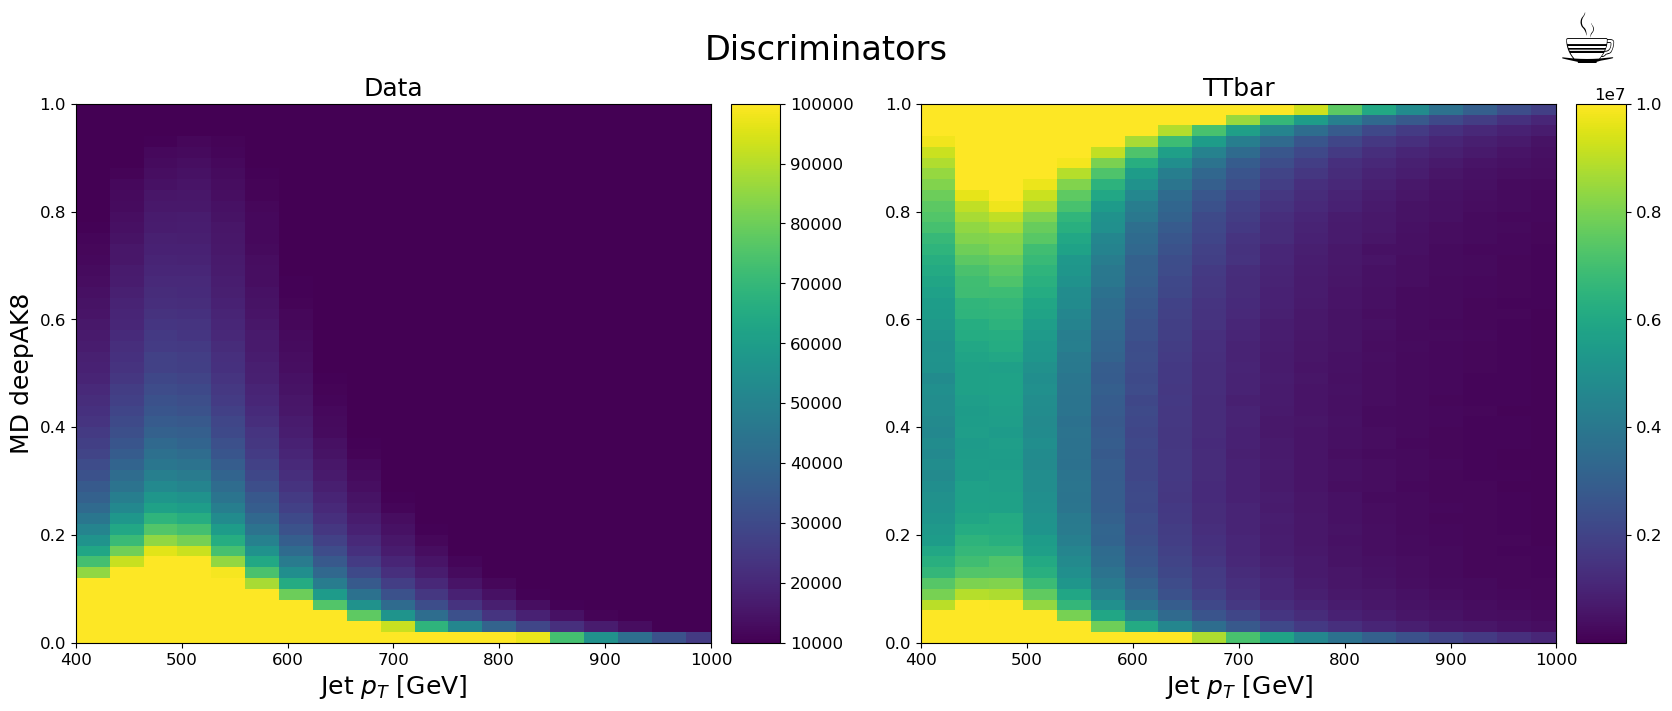

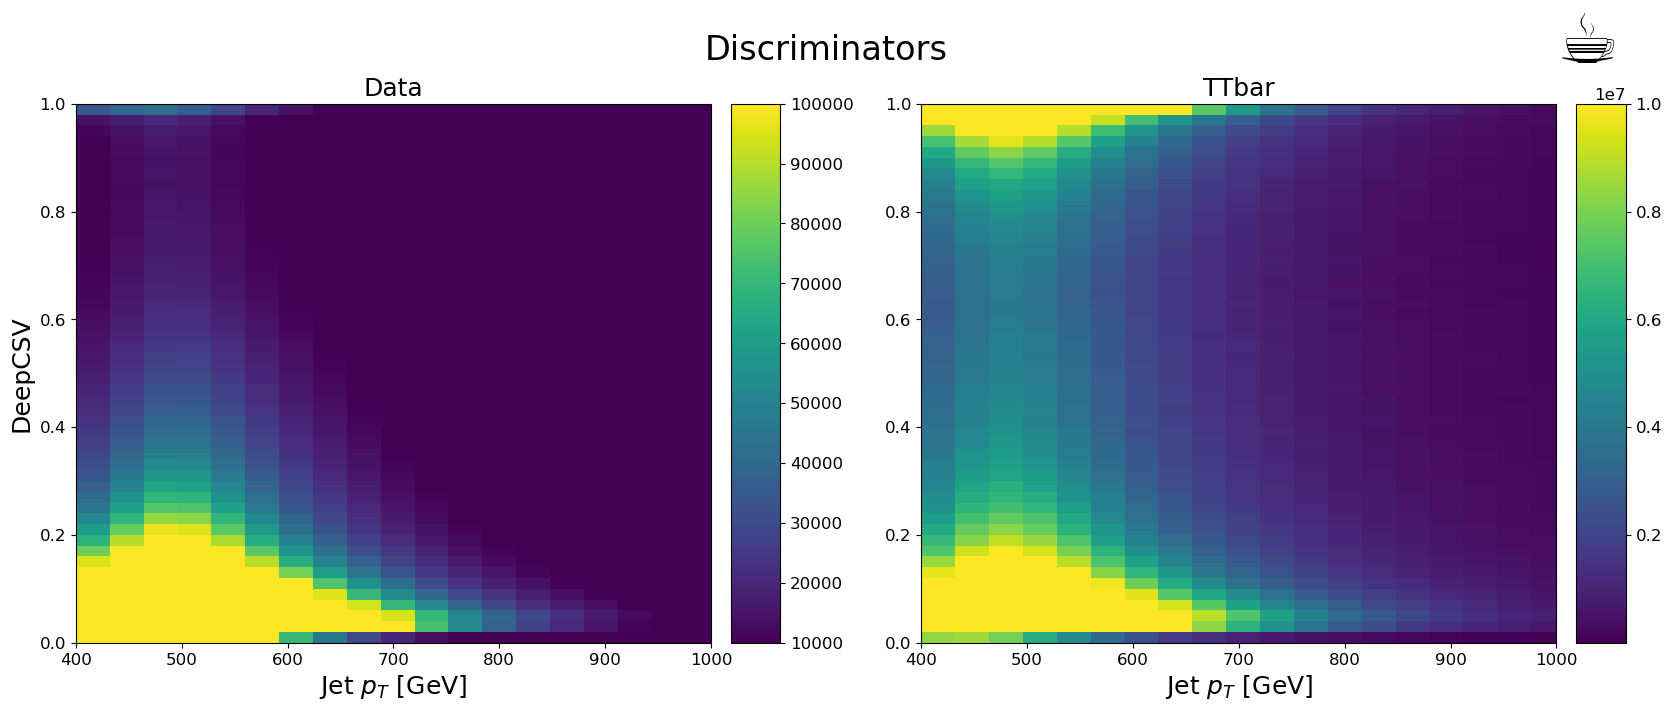

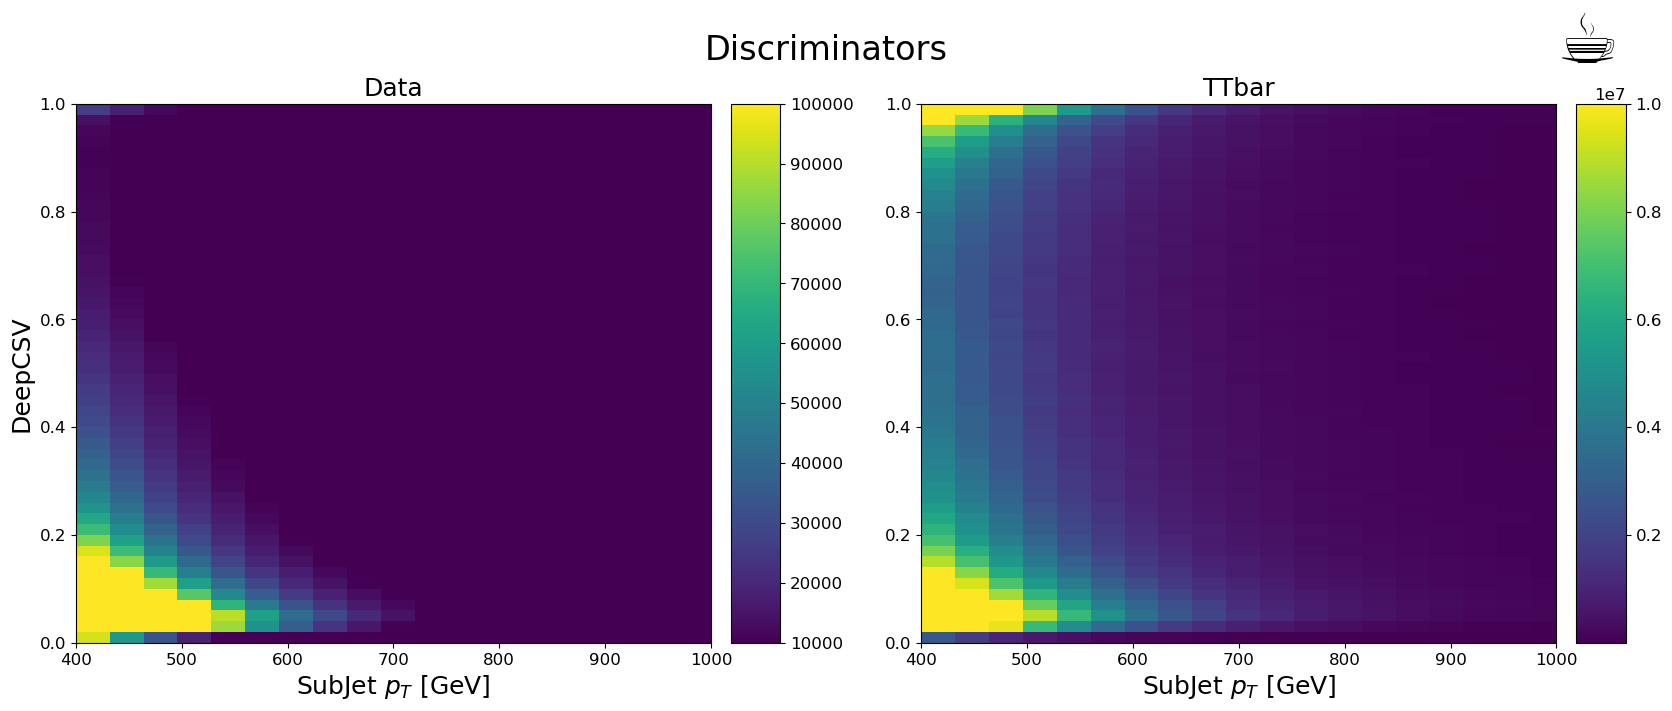

In [20]:
# ---- List the Histograms Here ---- #
list_of_hists_4vector = ['deepTagMD_TvsQCD', 'deepB_fatjet', 'deepB_subjet']

for ihist in list_of_hists_4vector:
    # -- split histograms into subdirectories -- #
    # SaveDirectory = f'{maindirectory}/UnweightedAnalysisPlots/{yeardir}{btagdir}{oddir}{btagType}{ihist}/{PlotType}/'
    SaveDirectory = f'{maindirectory}/DiscriminatorPlots/{yeardir}{btagdir}{oddir}{btagType}'
    hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
     
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (axData, axTTbar) = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(20,7),
        # gridspec_kw={"height_ratios": (3, 1)},
        # sharex=True
    )
    
    fig.subplots_adjust(hspace=.07)
    filename = ihist + '_2D_pT.png'
    fig.suptitle('Discriminators', fontsize='xx-large')

    Data_hist = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, xaxis)
    TTbar_hist = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, xaxis, UnscaledTT)


#    ===========================================================================
#    M     M    A    K     K EEEEEEE     PPPPPP  L         OOO   TTTTTTT   SSSSS     
#    MM   MM   A A   K   K   E           P     P L        O   O     T     S          
#    M M M M  A   A  K K     E           P     P L       O     O    T    S           
#    M  M  M  AAAAA  KKk     EEEEEEE     PPPPPP  L       O     O    T     SSSSS      
#    M     M A     A K  K    E           P       L       O     O    T          S     
#    M     M A     A K   K   E           P       L        O   O     T         S      
#    M     M A     A K   K   EEEEEEE     P       LLLLLLL   OOO      T    SSSSS 
#    ===========================================================================

    #---- Plot Data ----#
    #-----------------------------------------------------------------#
    Data_hist.plot2d(ax=axData, vmin=10**4, vmax=10**5)#, histtype='fill', color='yellow')
    TTbar_hist.plot2d(ax=axTTbar, vmin=10**3, vmax=10**7)#, histtype='fill', color='red')
    
    plt.autoscale(enable=True, axis='y')
    axData.set_title('Data')
    axTTbar.set_title('TTbar')
    axTTbar.set_ylabel('')
    
    # if ihist == 'deepTagMD_TvsQCD':
    if xaxis == 'pt':
        axData.set_xlim(400., 1000.)
        axTTbar.set_xlim(400., 1000.)
    if xaxis == 'mass':
        axData.set_xlim(0., 300.)
        axTTbar.set_xlim(0., 300.)

    #---- Labeling ----#
    coffee = plt.text(1.0, 1.05, u"☕",
                  fontsize=50,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=axTTbar.transAxes
                 )
    if saveOn:
        plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        print(SaveDirectory+filename)

In [21]:
xaxis = 'mass'
saveOn = False

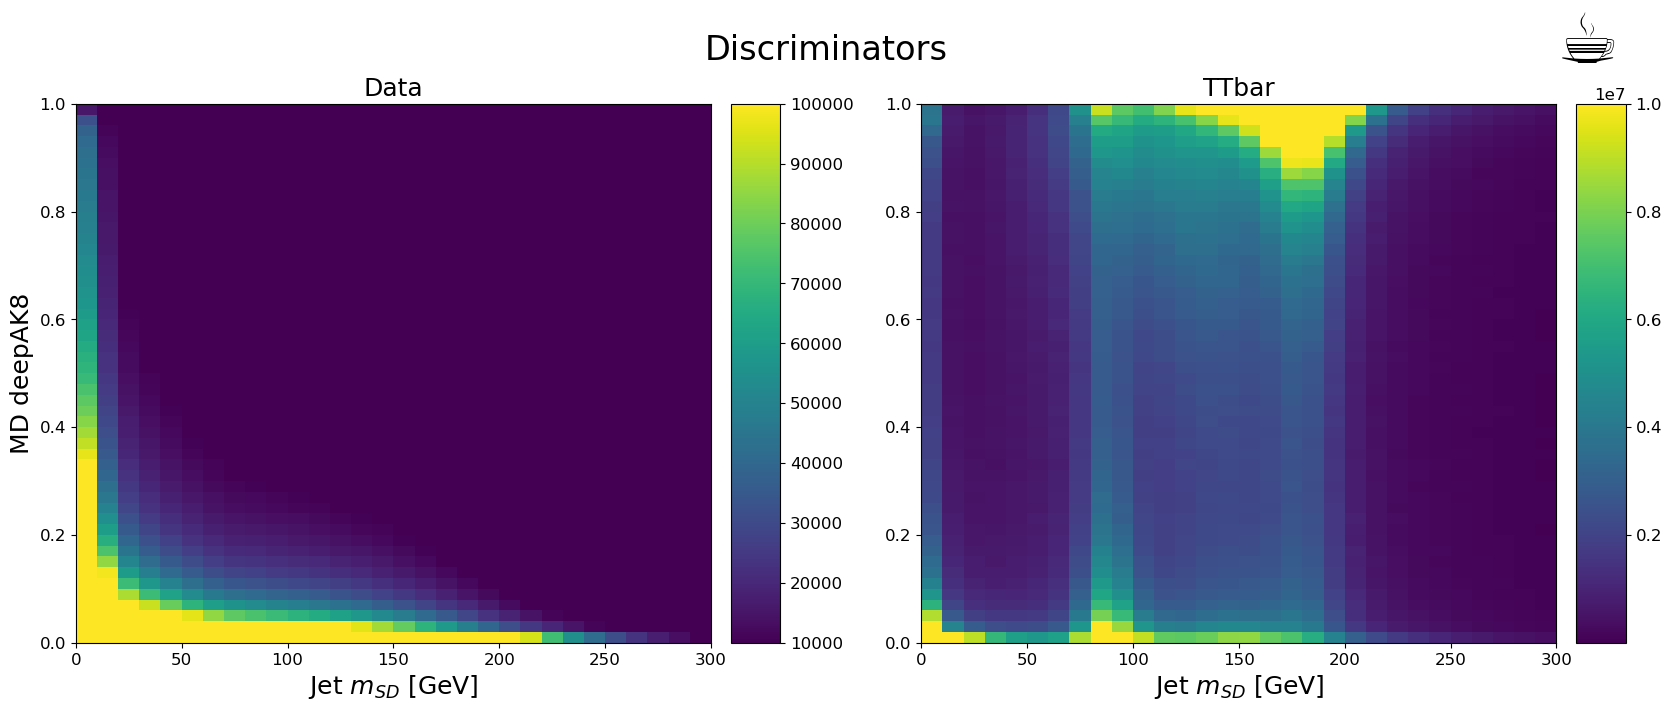

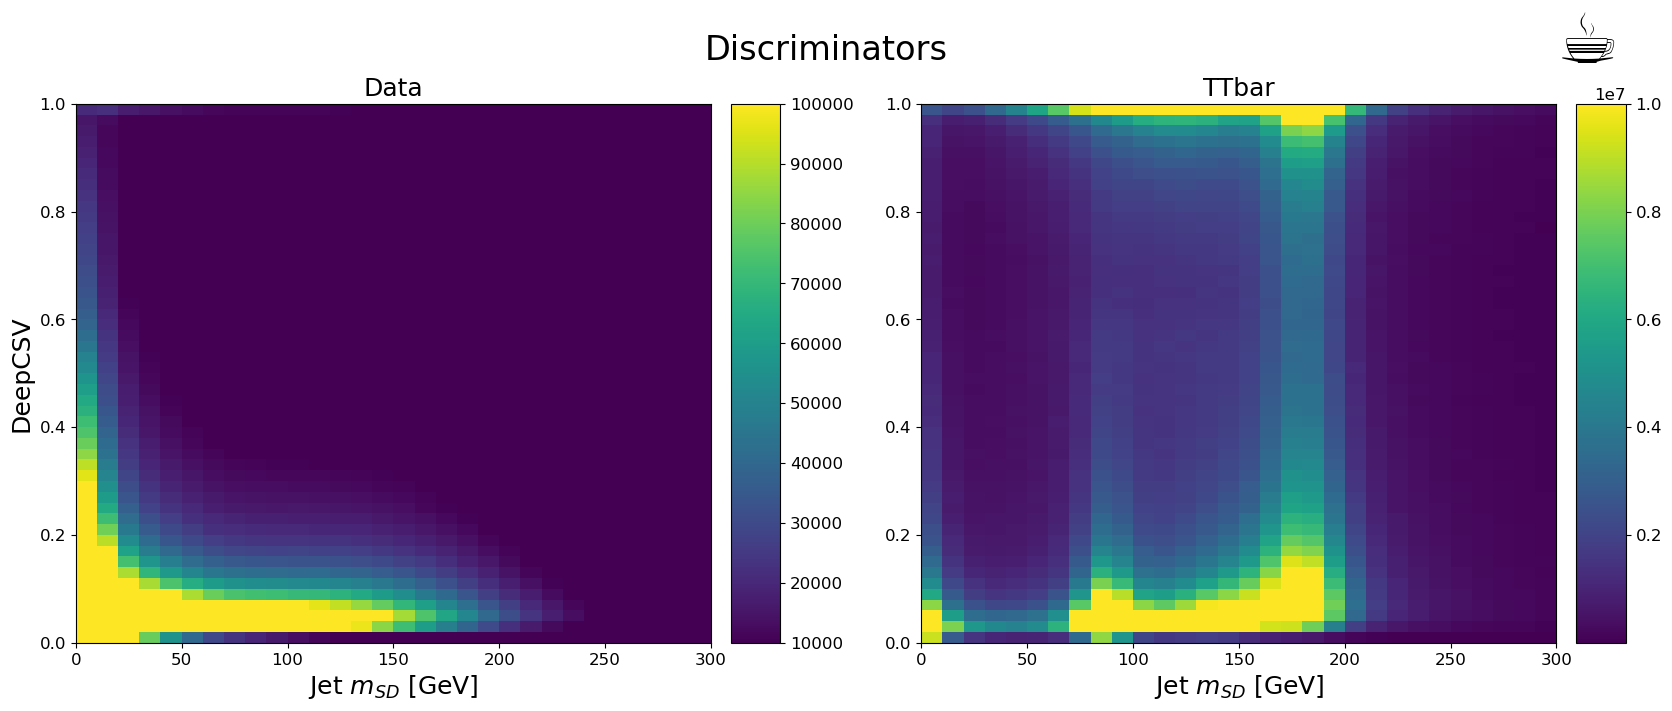

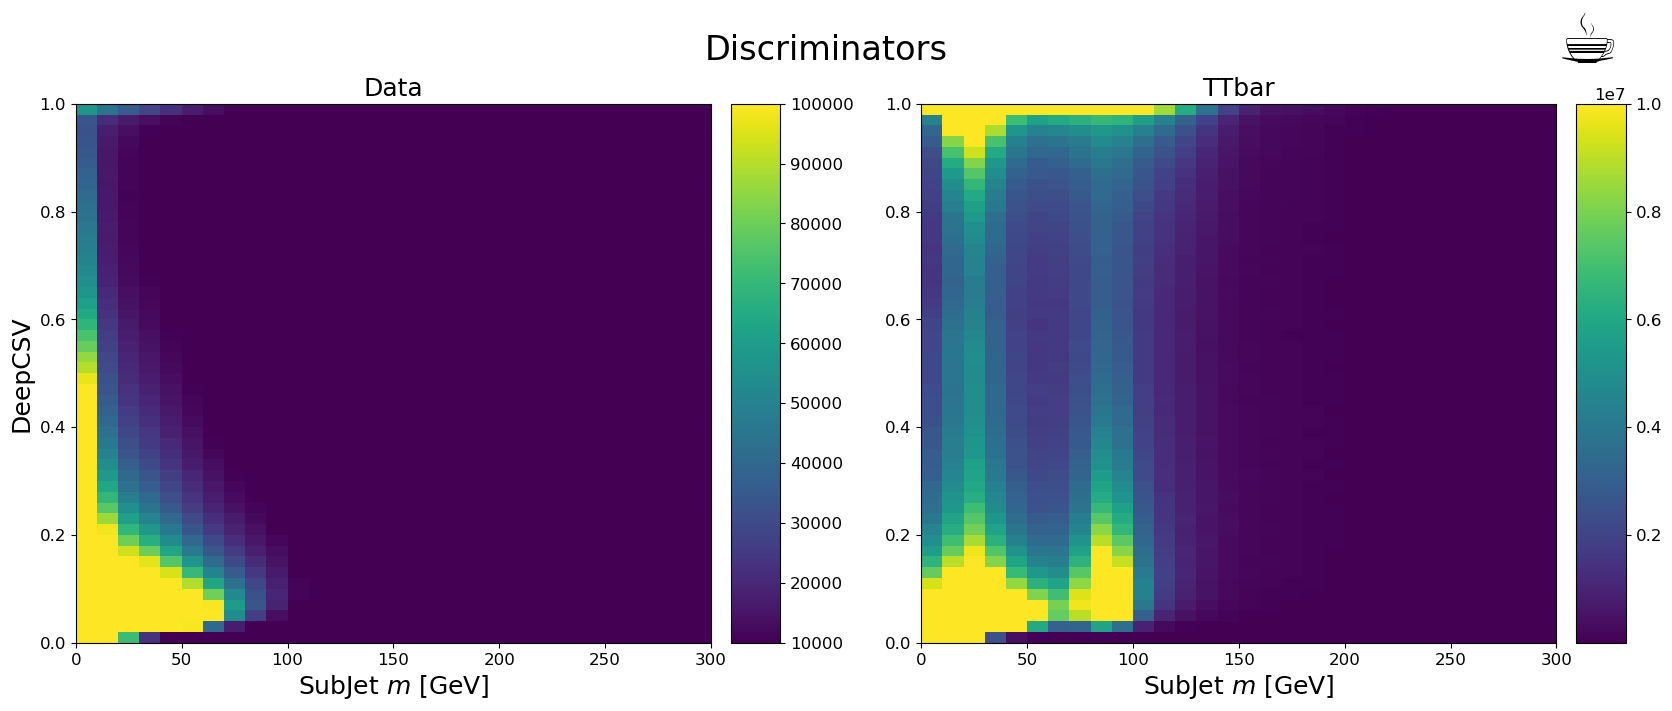

In [22]:
# ---- List the Histograms Here ---- #
list_of_hists_4vector = ['deepTagMD_TvsQCD', 'deepB_fatjet', 'deepB_subjet']

for ihist in list_of_hists_4vector:
    # -- split histograms into subdirectories -- #
    # SaveDirectory = f'{maindirectory}/UnweightedAnalysisPlots/{yeardir}{btagdir}{oddir}{btagType}{ihist}/{PlotType}/'
    SaveDirectory = f'{maindirectory}/DiscriminatorPlots/{yeardir}{btagdir}{oddir}{btagType}'
    hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
     
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, (axData, axTTbar) = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(20,7),
        # gridspec_kw={"height_ratios": (3, 1)},
        # sharex=True
    )
    
    fig.subplots_adjust(hspace=.07)
    filename = ihist + '_2D_mass.png'
    fig.suptitle('Discriminators', fontsize='xx-large')

    Data_hist = LD.AddEraDisc(JetHT2016_unweighted, 2016, ihist, xaxis)
    TTbar_hist = LM.ScaledTTbarDisc(TTbar2016_unweighted, 2016, ihist, xaxis, UnscaledTT)


#    ===========================================================================
#    M     M    A    K     K EEEEEEE     PPPPPP  L         OOO   TTTTTTT   SSSSS     
#    MM   MM   A A   K   K   E           P     P L        O   O     T     S          
#    M M M M  A   A  K K     E           P     P L       O     O    T    S           
#    M  M  M  AAAAA  KKk     EEEEEEE     PPPPPP  L       O     O    T     SSSSS      
#    M     M A     A K  K    E           P       L       O     O    T          S     
#    M     M A     A K   K   E           P       L        O   O     T         S      
#    M     M A     A K   K   EEEEEEE     P       LLLLLLL   OOO      T    SSSSS 
#    ===========================================================================

    #---- Plot Data ----#
    #-----------------------------------------------------------------#
    Data_hist.plot2d(ax=axData, vmin=10**4, vmax=10**5)#, histtype='fill', color='yellow')
    TTbar_hist.plot2d(ax=axTTbar, vmin=10**3, vmax=10**7)#, histtype='fill', color='red')
    
    plt.autoscale(enable=True, axis='y')
    axData.set_title('Data')
    axTTbar.set_title('TTbar')
    axTTbar.set_ylabel('')
    
    # if ihist == 'deepTagMD_TvsQCD':
    if xaxis == 'pt':
        axData.set_xlim(400., 1000.)
        axTTbar.set_xlim(400., 1000.)
    if xaxis == 'mass':
        axData.set_xlim(0., 300.)
        axTTbar.set_xlim(0., 300.)

    #---- Labeling ----#
    coffee = plt.text(1.0, 1.05, u"☕",
                  fontsize=50,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=axTTbar.transAxes
                 )
    if saveOn:
        plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        print(SaveDirectory+filename)